<a href="https://colab.research.google.com/github/khanmhmdi/Moe-llm-edge-computing/blob/main/Simple_Moe_classifiction_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# ------------------------------
# 1. Define Expert, GatingNetwork, and MoEBlock modules
# ------------------------------

class Expert(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Expert, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        return out

class GatingNetwork(nn.Module):
    def __init__(self, in_channels, num_experts):
        super(GatingNetwork, self).__init__()
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(in_channels, num_experts)

    def forward(self, x):
        batch_size, _, _, _ = x.size()
        # Global pooling: reduce each channel to a single value per image
        pooled = self.global_pool(x).view(batch_size, -1)  # Shape: [B, in_channels]
        logits = self.fc(pooled)  # Shape: [B, num_experts]
        weights = F.softmax(logits, dim=1)  # Gating weights across experts
        return weights

class MoEBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_experts=4):
        super(MoEBlock, self).__init__()
        self.num_experts = num_experts
        self.experts = nn.ModuleList([Expert(in_channels, out_channels) for _ in range(num_experts)])
        self.gate = GatingNetwork(in_channels, num_experts)
        # Aggregation layers: optional 1x1 convolution for mixing expert outputs
        self.out_conv = nn.Conv2d(out_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        # Compute gating weights for each expert; shape: [B, num_experts]
        gate_weights = self.gate(x)

        # Run input through each expert
        expert_outputs = [expert(x) for expert in self.experts]  # each: [B, out_channels, H, W]
        # Stack expert outputs along a new dimension: [B, num_experts, out_channels, H, W]
        expert_stack = torch.stack(expert_outputs, dim=1)

        # Expand gating weights dimensions so they can be broadcast multiplied with expert outputs
        gate_weights = gate_weights.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        # Weighted sum of experts; sum over the expert dim=1.
        out = (expert_stack * gate_weights).sum(dim=1)

        # Optionally process with additional conv and nonlinearity
        out = self.out_conv(out)
        out = self.bn(out)
        out = F.relu(out)
        return out

# ------------------------------
# 2. Define the MoE-based Classifier Model
# ------------------------------

class MoEClassifier(nn.Module):
    def __init__(self, num_classes=10, num_experts=4):
        super(MoEClassifier, self).__init__()
        # Since MNIST images are grayscale (1 channel) and 28x28 pixels,
        # we adjust the first layer accordingly.
        self.initial = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        # Downsample early to create a meaningful feature map.
        self.pool = nn.MaxPool2d(2)  # reduce spatial size by factor of 2

        # Stack MoE blocks
        self.moe_block1 = MoEBlock(32, 64, num_experts=num_experts)  # from 32 -> 64 channels
        self.moe_block2 = MoEBlock(64, 128, num_experts=num_experts) # from 64 -> 128 channels

        # Global average pooling and fully-connected classification layer
        self.global_pool = nn.AdaptiveAvgPool2d(1)  # output size: 1x1
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        # Initial convolution block
        x = self.initial(x)
        x = self.pool(x)  # size becomes 14x14

        # First MoEBlock
        x = self.moe_block1(x)
        x = self.pool(x)  # size becomes 7x7

        # Second MoEBlock
        x = self.moe_block2(x)
        # Global pooling
        x = self.global_pool(x)  # shape: [B, 128, 1, 1]
        x = x.view(x.size(0), -1)  # flatten to shape: [B, 128]
        logits = self.fc(x)        # shape: [B, num_classes]
        return logits

# ------------------------------
# 3. Setup DataLoader for the MNIST Dataset
# ------------------------------

def get_data_loaders(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.1307,), std=(0.3081,))  # MNIST normalization
    ])

    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, test_loader

# ------------------------------
# 4. Training and Testing Loops
# ------------------------------

def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate correct predictions
        _, predicted = torch.max(outputs, 1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

        if batch_idx % 100 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] "
                  f"Loss: {loss.item():.6f}")

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100. * correct / total
    print(f"Train Epoch: {epoch} Average Loss: {epoch_loss:.6f}, Accuracy: {correct}/{total} ({accuracy:.2f}%)")

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += predicted.eq(target).sum().item()

    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n")

# ------------------------------
# 5. Main
# ------------------------------

def main():
    # Check device (GPU if available)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # Hyperparameters:
    num_classes = 10
    num_experts = 4
    learning_rate = 0.001
    batch_size = 64
    num_epochs = 10

    # Prepare data loaders
    train_loader, test_loader = get_data_loaders(batch_size)

    # Create model instance
    model = MoEClassifier(num_classes=num_classes, num_experts=num_experts).to(device)

    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(1, num_epochs + 1):
        train(model, device, train_loader, optimizer, criterion, epoch)
        test(model, device, test_loader, criterion)

    # Save the model checkpoint
    torch.save(model.state_dict(), "moe_mnist_model.pth")
    print("Model saved as moe_mnist_model.pth")

if __name__ == '__main__':
    main()

Using device: cuda
Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 13.5MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 503kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.56MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.6MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Train Epoch: 1 [0/60000] Loss: 2.333817
Train Epoch: 1 [6400/60000] Loss: 0.265786
Train Epoch: 1 [12800/60000] Loss: 0.106941
Train Epoch: 1 [19200/60000] Loss: 0.047237
Train Epoch: 1 [25600/60000] Loss: 0.037406
Train Epoch: 1 [32000/60000] Loss: 0.068875
Train Epoch: 1 [38400/60000] Loss: 0.055456
Train Epoch: 1 [44800/60000] Loss: 0.039216
Train Epoch: 1 [51200/60000] Loss: 0.030849
Train Epoch: 1 [57600/60000] Loss: 0.039932
Train Epoch: 1 Average Loss: 0.167941, Accuracy: 58000/60000 (96.67%)

Test set: Average loss: 0.0781, Accuracy: 9769/10000 (97.69%)

Train Epoch: 2 [0/60000] Loss: 0.053851
Train Epoch: 2 [6400/60000] Loss: 0.051189
Train Epoch: 2 [12800/60000] Loss: 0.065953
Train Epoch: 2 [19200/60000] Loss: 0.028292
Train Epoch: 2 [25600/60000] Loss: 0.019002
Train Epoch: 2 [32000/60000] Loss: 0.020836
Train Epoch: 2 [38400/60000] Loss: 0.106400
Train Epoch: 2 [44800/60000] Loss: 0.019319
Train Epo

In [4]:
from torchvision import datasets, transforms

def get_cifar10_loaders(batch_size=128):
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                             std=[0.2023, 0.1994, 0.2010])
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                             std=[0.2023, 0.1994, 0.2010])
    ])

    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    test_dataset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, test_loader


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Expert(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Expert, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        return out

class GatingNetwork(nn.Module):
    def __init__(self, in_channels, num_experts):
        super(GatingNetwork, self).__init__()
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(in_channels, num_experts)

    def forward(self, x):
        batch_size, _, _, _ = x.size()
        pooled = self.global_pool(x).view(batch_size, -1)
        logits = self.fc(pooled)
        weights = F.softmax(logits, dim=1)
        return weights

class MoEBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_experts=4):
        super(MoEBlock, self).__init__()
        self.num_experts = num_experts
        self.experts = nn.ModuleList([Expert(in_channels, out_channels) for _ in range(num_experts)])
        self.gate = GatingNetwork(in_channels, num_experts)
        self.out_conv = nn.Conv2d(out_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x, return_gate=False):
        # Get gating network outputs.
        gate_weights = self.gate(x)  # shape: [batch, num_experts]
        # Process experts
        expert_outputs = [expert(x) for expert in self.experts]
        expert_stack = torch.stack(expert_outputs, dim=1)  # shape: [batch, num_experts, channels, H, W]
        # Reshape gating outputs to broadcast (batch, num_experts, 1, 1, 1)
        gate_weights_expanded = gate_weights.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        out = (expert_stack * gate_weights_expanded).sum(dim=1)
        out = self.out_conv(out)
        out = self.bn(out)
        out = F.relu(out)

        if return_gate:
            # Return both the output and the gating weights for analysis.
            return out, gate_weights
        return out


class MoEClassifier(nn.Module):
    def __init__(self, num_classes=10, num_experts=4):
        super(MoEClassifier, self).__init__()
        # Adjusting for 3-channel CIFAR images instead of 1-channel MNIST
        self.initial = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.pool = nn.MaxPool2d(2)  # 32x32 -> 16x16

        self.moe_block1 = MoEBlock(32, 64, num_experts=num_experts)  # Output: 64 channels, 16x16
        self.pool1 = nn.MaxPool2d(2)  # 16x16 -> 8x8

        self.moe_block2 = MoEBlock(64, 128, num_experts=num_experts)  # Output: 128 channels, 8x8
        self.pool2 = nn.MaxPool2d(2)  # 8x8 -> 4x4

        self.global_pool = nn.AdaptiveAvgPool2d(1)  # 4x4 -> 1x1
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.initial(x)
        x = self.pool(x)

        x = self.moe_block1(x)
        x = self.pool1(x)

        x = self.moe_block2(x)
        x = self.pool2(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        return logits


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Assume MoEClassifier, MoEBlock, GatingNetwork, Expert are defined as above
import matplotlib.pyplot as plt
import numpy as np

def plot_gating_statistics(gating_stats):
    for layer, stats in gating_stats.items():
        experts = np.arange(len(stats))
        stats = stats.cpu().numpy()  if hasattr(stats, 'cpu') else stats  # Convert to numpy array
        plt.figure(figsize=(6,4))
        plt.bar(experts, stats, color='skyblue')
        plt.xlabel('Expert Index')
        plt.ylabel('Average Gate Weight')
        plt.title(f'Average Selection Weight per Expert in {layer}')
        plt.xticks(experts)
        plt.ylim(0, np.max(stats) * 1.1)
        plt.show()

def get_cifar10_loaders(batch_size=128):
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                             std=[0.2023, 0.1994, 0.2010])
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                             std=[0.2023, 0.1994, 0.2010])
    ])

    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    test_dataset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, test_loader

def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

        if batch_idx % 100 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.6f}")

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100. * correct / total
    print(f"Train Epoch: {epoch} Avg Loss: {epoch_loss:.6f}, Accuracy: {accuracy:.2f}%")

def evaluate_gating(model, device, test_loader):
    model.eval()

    # Initialize accumulators for each MoE block. They will have shape [num_experts]
    gating_stats = {
        'moe_block1': None,
        'moe_block2': None
    }
    count = 0

    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            count += data.size(0)

            # Pass through initial layers
            x = model.initial(data)
            x = model.pool(x)

            # For moe_block1: We use the modified forward that returns gating outputs.
            x, gate1 = model.moe_block1(x, return_gate=True)
            # Then continue with pooling
            x = model.pool1(x)

            # For moe_block2:
            x, gate2 = model.moe_block2(x, return_gate=True)
            x = model.pool2(x)

            # You can sum over the batch to accumulate gating information.
            if gating_stats['moe_block1'] is None:
                gating_stats['moe_block1'] = gate1.sum(dim=0)  # shape: [num_experts]
            else:
                gating_stats['moe_block1'] += gate1.sum(dim=0)

            if gating_stats['moe_block2'] is None:
                gating_stats['moe_block2'] = gate2.sum(dim=0)
            else:
                gating_stats['moe_block2'] += gate2.sum(dim=0)

    # Average over total samples:
    gating_stats['moe_block1'] /= count
    gating_stats['moe_block2'] /= count

    return gating_stats

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # Hyperparameters
    num_classes = 10           # change to 100 for CIFAR-100 or 1000 for ImageNet
    num_experts = 4            # or try increasing this number
    learning_rate = 0.001
    batch_size = 128
    num_epochs = 1            # Adjust epoch count as needed

    train_loader, test_loader = get_cifar10_loaders(batch_size)
    model = MoEClassifier(num_classes=num_classes, num_experts=num_experts).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Optionally, add a learning rate scheduler:
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

    for epoch in range(1, num_epochs + 1):
        train(model, device, train_loader, optimizer, criterion, epoch)
        test(model, device, test_loader, criterion)
        scheduler.step()

    torch.save(model.state_dict(), "moe_cifar10_model.pth")
    print("Model saved as moe_cifar10_model.pth")
    # After training is complete
    gating_stats = evaluate_gating(model, device, test_loader)
    plot_gating_statistics(gating_stats)

if __name__ == '__main__':
    main()


RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x64 and 128x4)

Files already downloaded and verified
Files already downloaded and verified
Starting training on CIFAR-10...
Epoch [1] Batch [10/391] Loss: 2.0114
Epoch [1] Batch [20/391] Loss: 2.0756
Epoch [1] Batch [30/391] Loss: 1.7638
Epoch [1] Batch [40/391] Loss: 1.8142
Epoch [1] Batch [50/391] Loss: 1.7952
Epoch [1] Batch [60/391] Loss: 1.7575
Epoch [1] Batch [70/391] Loss: 1.8735
Epoch [1] Batch [80/391] Loss: 1.6770
Epoch [1] Batch [90/391] Loss: 1.6578
Epoch [1] Batch [100/391] Loss: 1.7042
Epoch [1] Batch [110/391] Loss: 1.7928
Epoch [1] Batch [120/391] Loss: 1.4650
Epoch [1] Batch [130/391] Loss: 1.6663
Epoch [1] Batch [140/391] Loss: 1.6523
Epoch [1] Batch [150/391] Loss: 1.5009
Epoch [1] Batch [160/391] Loss: 1.6281
Epoch [1] Batch [170/391] Loss: 1.6263
Epoch [1] Batch [180/391] Loss: 1.7200
Epoch [1] Batch [190/391] Loss: 1.4688
Epoch [1] Batch [200/391] Loss: 1.4831
Epoch [1] Batch [210/391] Loss: 1.6581
Epoch [1] Batch [220/391] Loss: 1.5843
Epoch [1] Batch [230/391] Loss: 1.5261
Epo

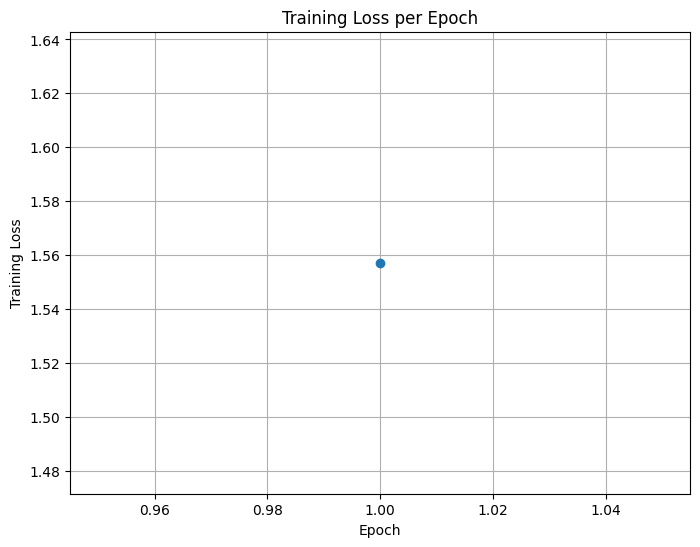

Test Accuracy on CIFAR-10: 47.23%


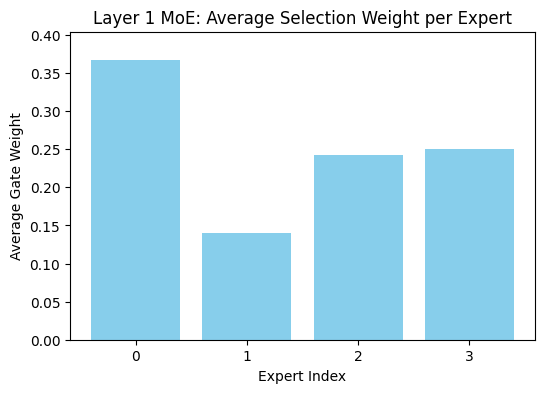

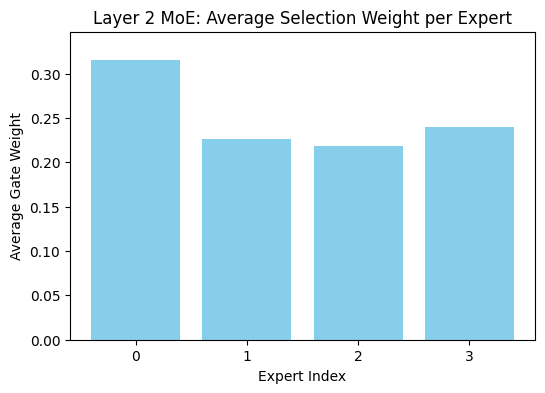

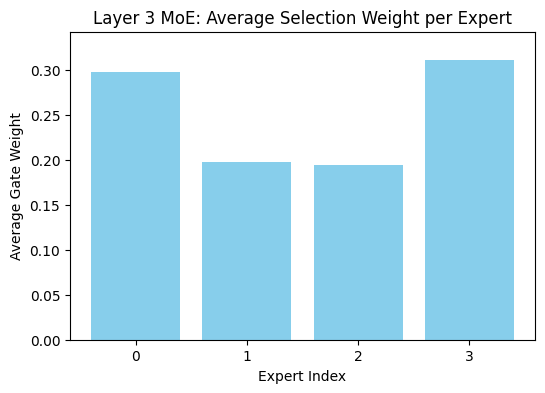

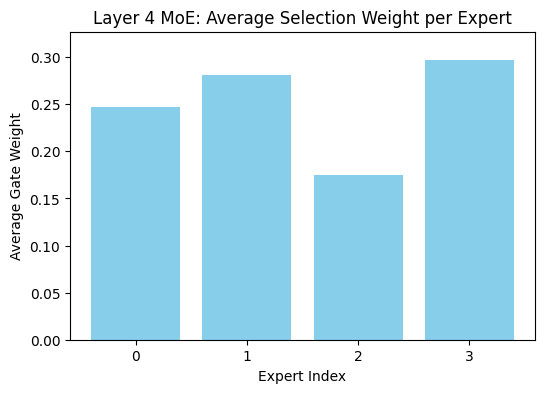

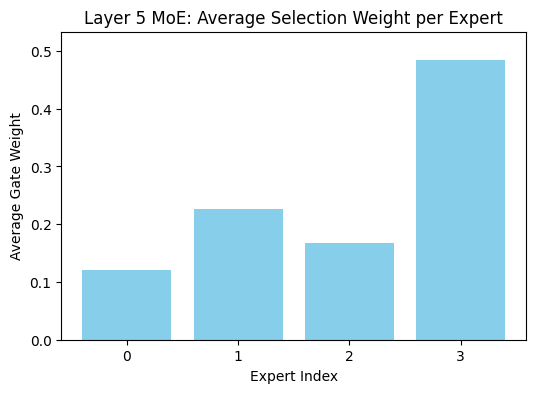

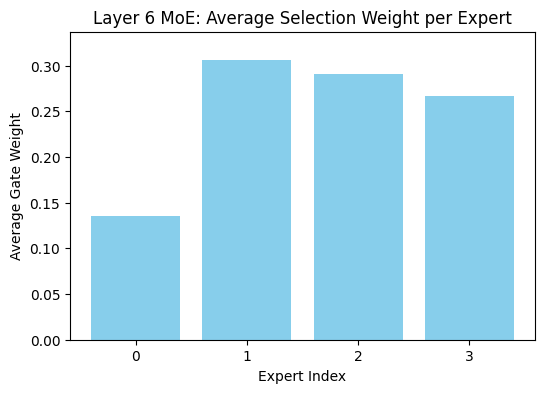

Epoch [2] Batch [10/391] Loss: 1.3281
Epoch [2] Batch [20/391] Loss: 1.3348
Epoch [2] Batch [30/391] Loss: 1.3789
Epoch [2] Batch [40/391] Loss: 1.1892
Epoch [2] Batch [50/391] Loss: 1.3983
Epoch [2] Batch [60/391] Loss: 1.2692
Epoch [2] Batch [70/391] Loss: 1.1312
Epoch [2] Batch [80/391] Loss: 1.2185
Epoch [2] Batch [90/391] Loss: 1.1210
Epoch [2] Batch [100/391] Loss: 1.2725
Epoch [2] Batch [110/391] Loss: 1.3291
Epoch [2] Batch [120/391] Loss: 1.2353
Epoch [2] Batch [130/391] Loss: 1.4915
Epoch [2] Batch [140/391] Loss: 1.4119
Epoch [2] Batch [150/391] Loss: 1.1137
Epoch [2] Batch [160/391] Loss: 1.0654
Epoch [2] Batch [170/391] Loss: 1.0292
Epoch [2] Batch [180/391] Loss: 1.2578
Epoch [2] Batch [190/391] Loss: 1.0546
Epoch [2] Batch [200/391] Loss: 1.3366
Epoch [2] Batch [210/391] Loss: 1.2852
Epoch [2] Batch [220/391] Loss: 1.3390
Epoch [2] Batch [230/391] Loss: 1.0403
Epoch [2] Batch [240/391] Loss: 1.1939
Epoch [2] Batch [250/391] Loss: 1.3885
Epoch [2] Batch [260/391] Loss: 1.

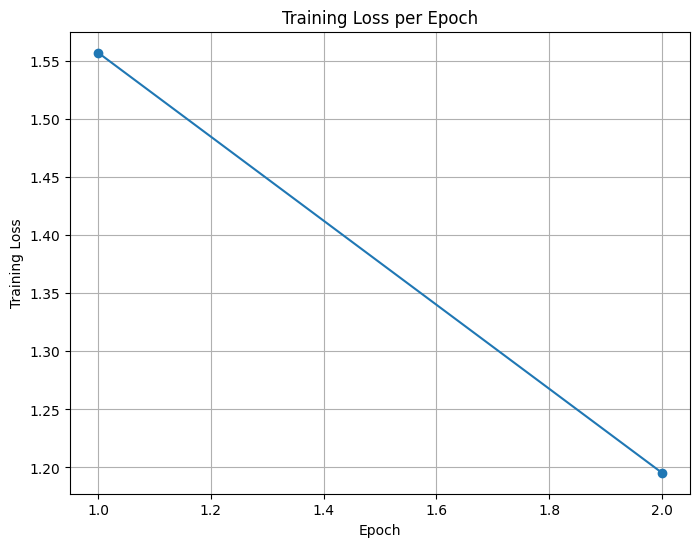

Test Accuracy on CIFAR-10: 57.91%


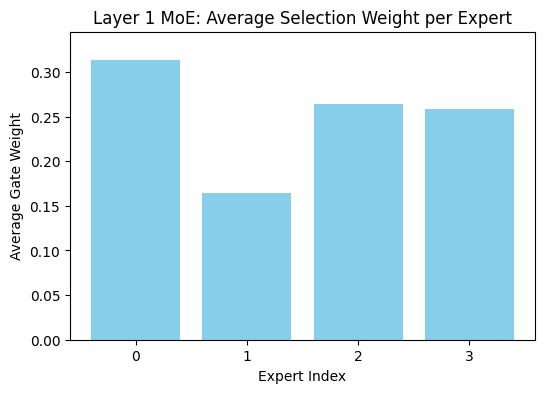

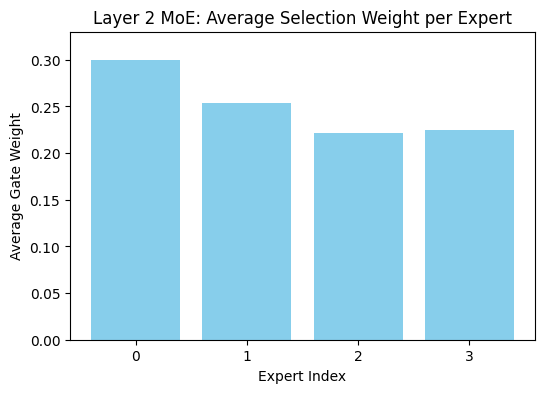

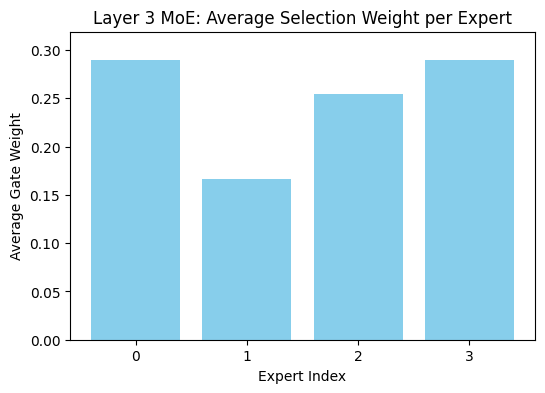

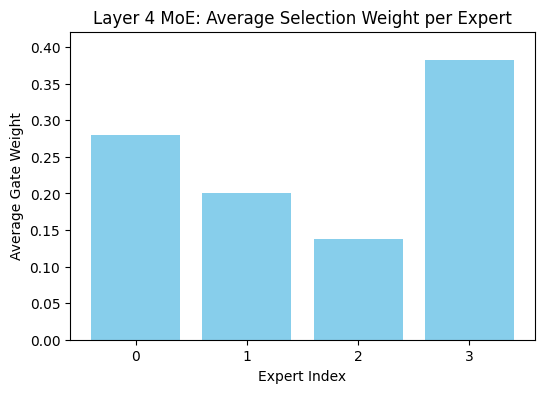

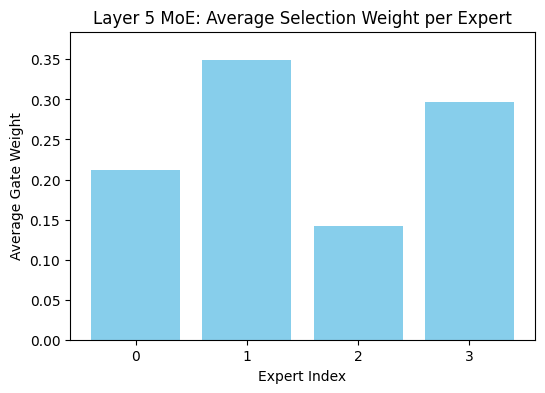

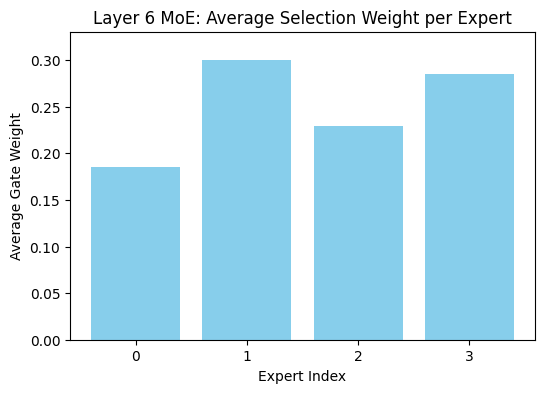

Epoch [3] Batch [10/391] Loss: 0.9553
Epoch [3] Batch [20/391] Loss: 1.1262
Epoch [3] Batch [30/391] Loss: 1.0357
Epoch [3] Batch [40/391] Loss: 1.1535
Epoch [3] Batch [50/391] Loss: 1.0201
Epoch [3] Batch [60/391] Loss: 1.1972
Epoch [3] Batch [70/391] Loss: 0.9775
Epoch [3] Batch [80/391] Loss: 1.2717
Epoch [3] Batch [90/391] Loss: 0.9128
Epoch [3] Batch [100/391] Loss: 0.7355
Epoch [3] Batch [110/391] Loss: 1.1002
Epoch [3] Batch [120/391] Loss: 1.0225
Epoch [3] Batch [130/391] Loss: 1.0433
Epoch [3] Batch [140/391] Loss: 1.0904
Epoch [3] Batch [150/391] Loss: 1.0292
Epoch [3] Batch [160/391] Loss: 1.1718
Epoch [3] Batch [170/391] Loss: 1.0066
Epoch [3] Batch [180/391] Loss: 0.9697
Epoch [3] Batch [190/391] Loss: 1.0227
Epoch [3] Batch [200/391] Loss: 0.9912
Epoch [3] Batch [210/391] Loss: 0.9723
Epoch [3] Batch [220/391] Loss: 1.0539
Epoch [3] Batch [230/391] Loss: 1.0189
Epoch [3] Batch [240/391] Loss: 0.9755
Epoch [3] Batch [250/391] Loss: 0.8548
Epoch [3] Batch [260/391] Loss: 0.

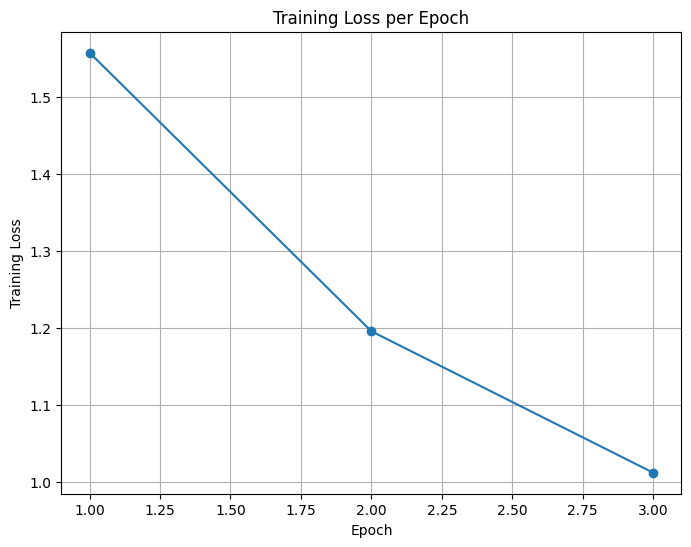

Test Accuracy on CIFAR-10: 63.07%


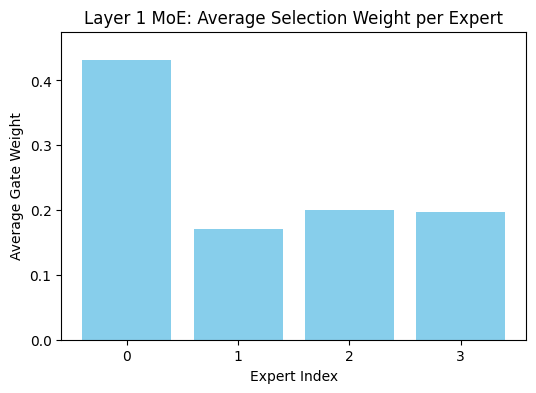

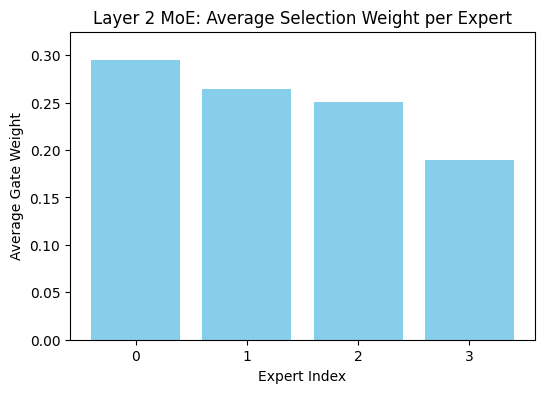

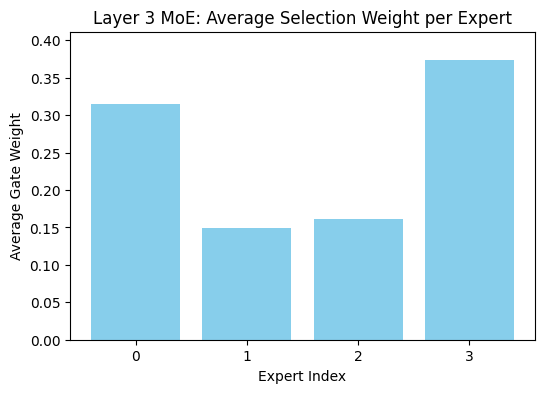

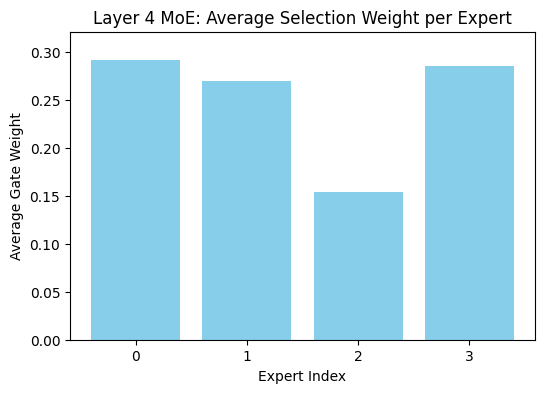

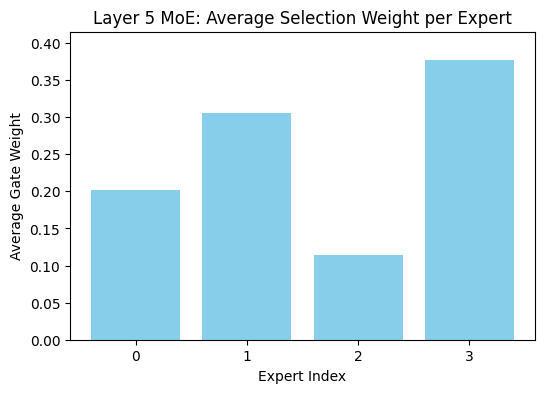

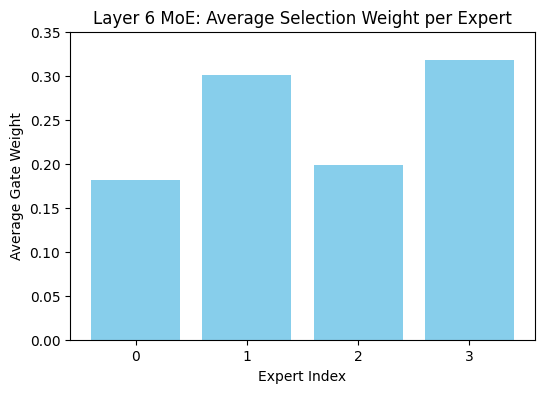

Epoch [4] Batch [10/391] Loss: 0.8398
Epoch [4] Batch [20/391] Loss: 1.0513
Epoch [4] Batch [30/391] Loss: 1.0064
Epoch [4] Batch [40/391] Loss: 0.8959
Epoch [4] Batch [50/391] Loss: 1.0240
Epoch [4] Batch [60/391] Loss: 0.9325
Epoch [4] Batch [70/391] Loss: 0.9282
Epoch [4] Batch [80/391] Loss: 0.9099
Epoch [4] Batch [90/391] Loss: 0.9836
Epoch [4] Batch [100/391] Loss: 1.0685
Epoch [4] Batch [110/391] Loss: 0.8971
Epoch [4] Batch [120/391] Loss: 0.9949
Epoch [4] Batch [130/391] Loss: 0.6905
Epoch [4] Batch [140/391] Loss: 0.8365
Epoch [4] Batch [150/391] Loss: 0.8566
Epoch [4] Batch [160/391] Loss: 0.9251
Epoch [4] Batch [170/391] Loss: 0.8302
Epoch [4] Batch [180/391] Loss: 0.9997
Epoch [4] Batch [190/391] Loss: 0.9624
Epoch [4] Batch [200/391] Loss: 0.8972
Epoch [4] Batch [210/391] Loss: 0.8602
Epoch [4] Batch [220/391] Loss: 1.0428
Epoch [4] Batch [230/391] Loss: 0.8231
Epoch [4] Batch [240/391] Loss: 0.9198
Epoch [4] Batch [250/391] Loss: 0.8033
Epoch [4] Batch [260/391] Loss: 0.

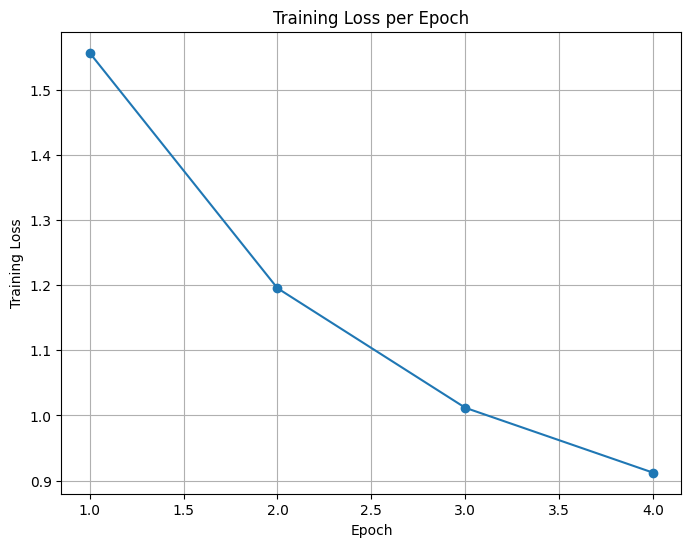

Test Accuracy on CIFAR-10: 67.93%


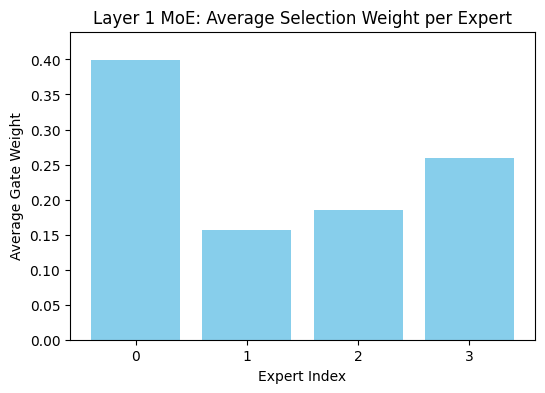

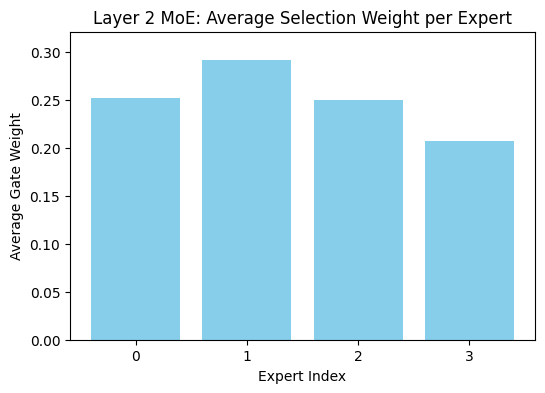

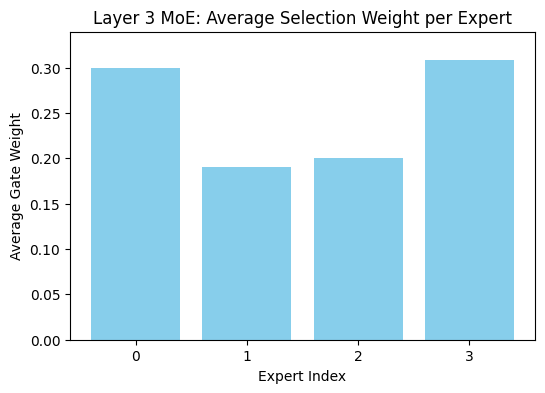

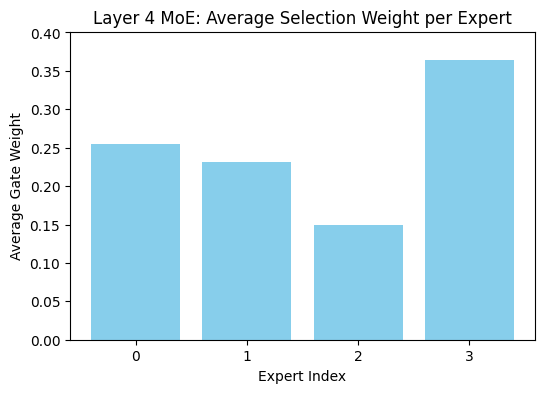

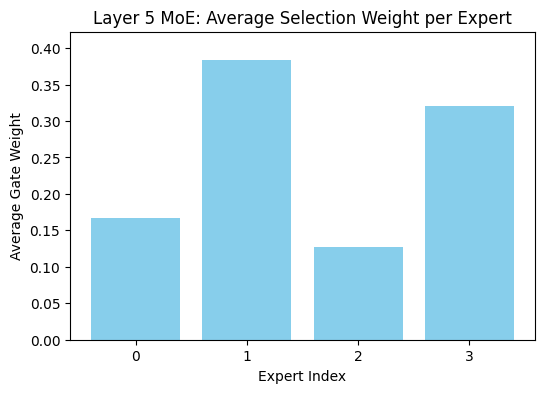

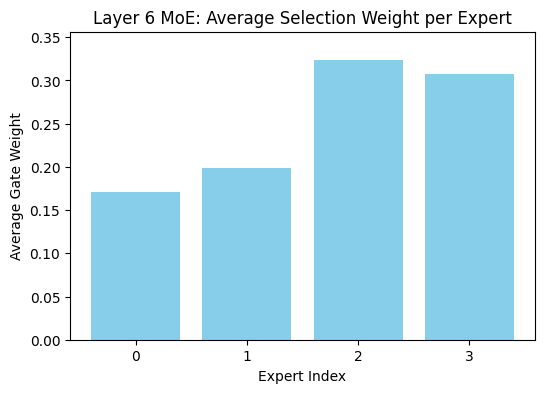

Epoch [5] Batch [10/391] Loss: 1.0678
Epoch [5] Batch [20/391] Loss: 0.8948
Epoch [5] Batch [30/391] Loss: 0.8734
Epoch [5] Batch [40/391] Loss: 0.7454
Epoch [5] Batch [50/391] Loss: 0.9591
Epoch [5] Batch [60/391] Loss: 0.7688
Epoch [5] Batch [70/391] Loss: 0.9160
Epoch [5] Batch [80/391] Loss: 0.8296
Epoch [5] Batch [90/391] Loss: 0.8517
Epoch [5] Batch [100/391] Loss: 0.8902
Epoch [5] Batch [110/391] Loss: 0.6943
Epoch [5] Batch [120/391] Loss: 0.8380
Epoch [5] Batch [130/391] Loss: 0.8739
Epoch [5] Batch [140/391] Loss: 0.8398
Epoch [5] Batch [150/391] Loss: 0.8187
Epoch [5] Batch [160/391] Loss: 0.8296
Epoch [5] Batch [170/391] Loss: 1.0524
Epoch [5] Batch [180/391] Loss: 0.8494
Epoch [5] Batch [190/391] Loss: 0.6588
Epoch [5] Batch [200/391] Loss: 0.7612
Epoch [5] Batch [210/391] Loss: 0.7018
Epoch [5] Batch [220/391] Loss: 0.8517
Epoch [5] Batch [230/391] Loss: 0.8482
Epoch [5] Batch [240/391] Loss: 0.6885
Epoch [5] Batch [250/391] Loss: 0.6612
Epoch [5] Batch [260/391] Loss: 0.

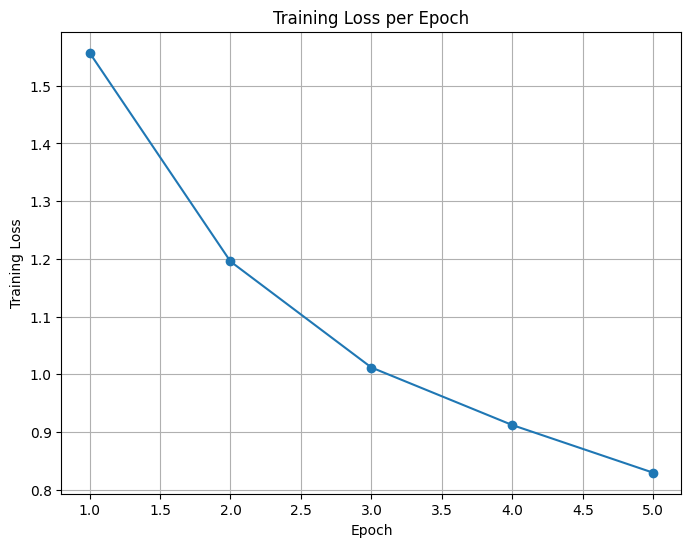

Test Accuracy on CIFAR-10: 71.47%


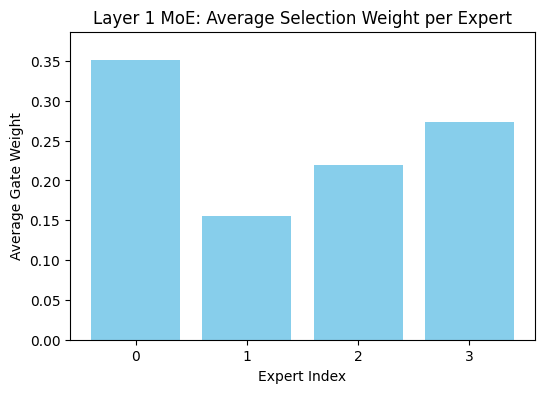

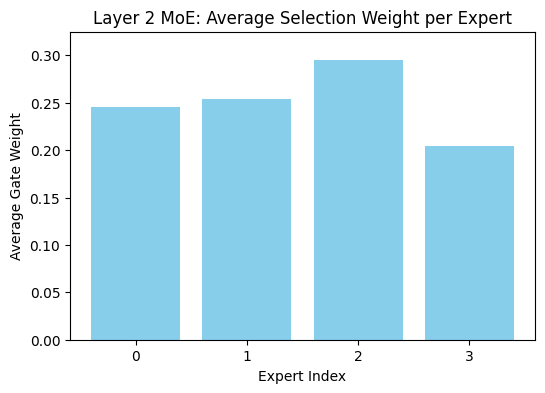

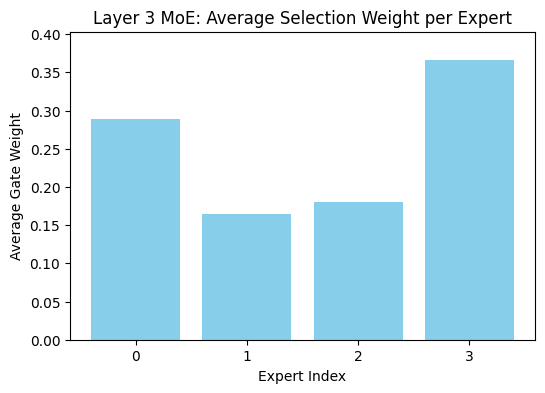

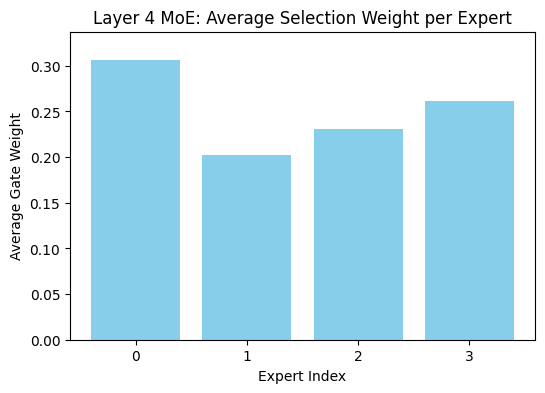

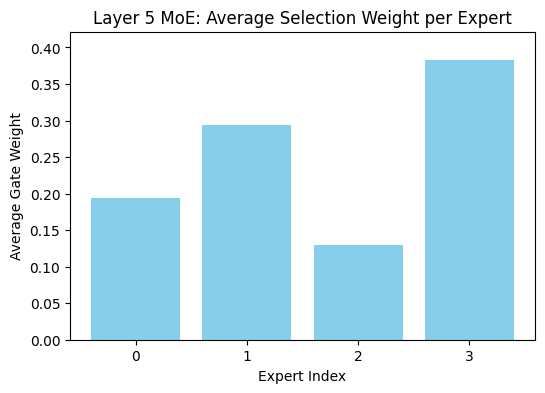

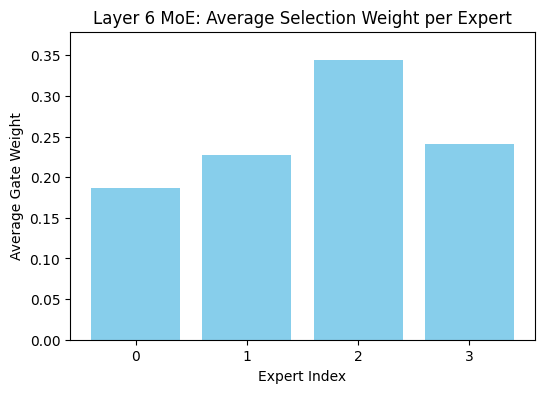

Epoch [6] Batch [10/391] Loss: 0.8864
Epoch [6] Batch [20/391] Loss: 0.6408
Epoch [6] Batch [30/391] Loss: 0.7927
Epoch [6] Batch [40/391] Loss: 0.6668
Epoch [6] Batch [50/391] Loss: 0.5682
Epoch [6] Batch [60/391] Loss: 0.9112
Epoch [6] Batch [70/391] Loss: 0.7466
Epoch [6] Batch [80/391] Loss: 0.7892
Epoch [6] Batch [90/391] Loss: 0.7241
Epoch [6] Batch [100/391] Loss: 0.7421
Epoch [6] Batch [110/391] Loss: 0.6451
Epoch [6] Batch [120/391] Loss: 0.7839
Epoch [6] Batch [130/391] Loss: 0.7321
Epoch [6] Batch [140/391] Loss: 0.6273
Epoch [6] Batch [150/391] Loss: 0.6991
Epoch [6] Batch [160/391] Loss: 0.6967
Epoch [6] Batch [170/391] Loss: 0.6083
Epoch [6] Batch [180/391] Loss: 0.6608
Epoch [6] Batch [190/391] Loss: 0.7730
Epoch [6] Batch [200/391] Loss: 0.6898
Epoch [6] Batch [210/391] Loss: 0.6533
Epoch [6] Batch [220/391] Loss: 0.6046
Epoch [6] Batch [230/391] Loss: 0.5539
Epoch [6] Batch [240/391] Loss: 0.5970
Epoch [6] Batch [250/391] Loss: 0.7129
Epoch [6] Batch [260/391] Loss: 0.

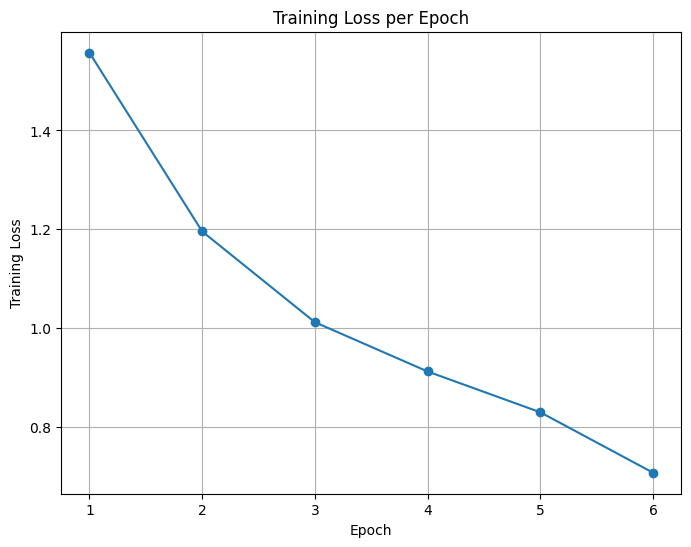

Test Accuracy on CIFAR-10: 75.24%


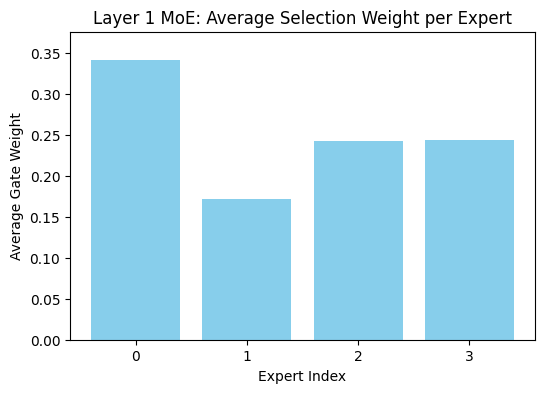

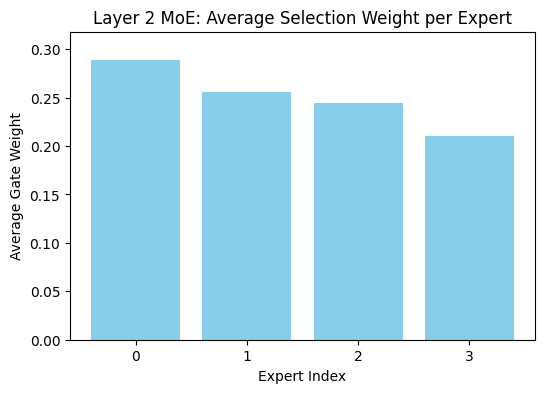

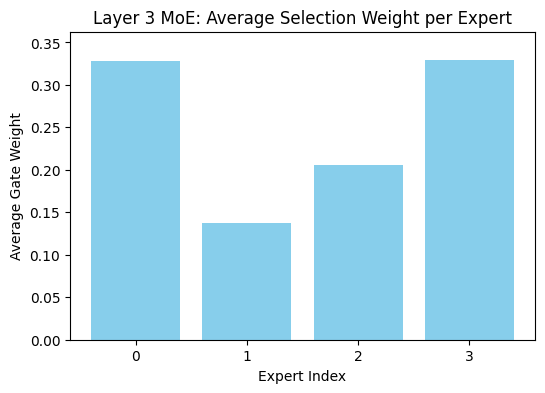

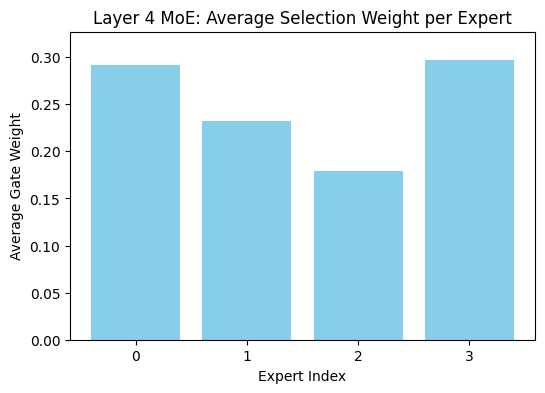

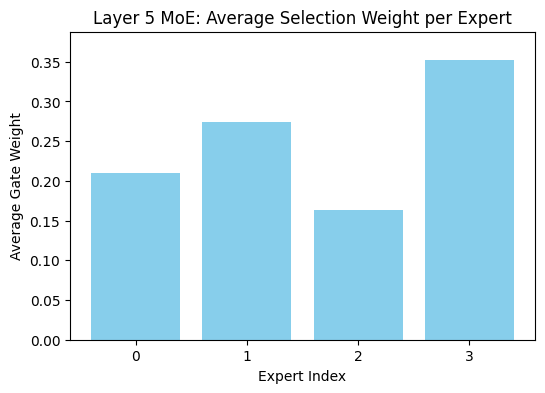

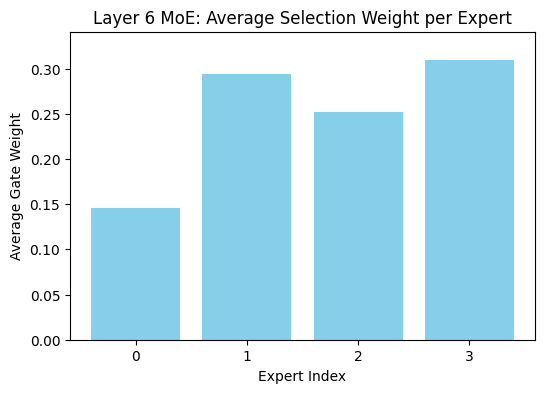

Epoch [7] Batch [10/391] Loss: 0.6983
Epoch [7] Batch [20/391] Loss: 0.6879
Epoch [7] Batch [30/391] Loss: 0.7020
Epoch [7] Batch [40/391] Loss: 0.8221
Epoch [7] Batch [50/391] Loss: 0.4740
Epoch [7] Batch [60/391] Loss: 0.6004
Epoch [7] Batch [70/391] Loss: 0.6410
Epoch [7] Batch [80/391] Loss: 0.8174
Epoch [7] Batch [90/391] Loss: 0.7312
Epoch [7] Batch [100/391] Loss: 0.6380
Epoch [7] Batch [110/391] Loss: 0.6626
Epoch [7] Batch [120/391] Loss: 0.6984
Epoch [7] Batch [130/391] Loss: 0.6985
Epoch [7] Batch [140/391] Loss: 0.5977
Epoch [7] Batch [150/391] Loss: 0.7689
Epoch [7] Batch [160/391] Loss: 0.6278
Epoch [7] Batch [170/391] Loss: 0.6797
Epoch [7] Batch [180/391] Loss: 0.6166
Epoch [7] Batch [190/391] Loss: 0.7484
Epoch [7] Batch [200/391] Loss: 0.7466
Epoch [7] Batch [210/391] Loss: 0.6030
Epoch [7] Batch [220/391] Loss: 0.6646
Epoch [7] Batch [230/391] Loss: 0.6116
Epoch [7] Batch [240/391] Loss: 0.7759
Epoch [7] Batch [250/391] Loss: 0.6615
Epoch [7] Batch [260/391] Loss: 0.

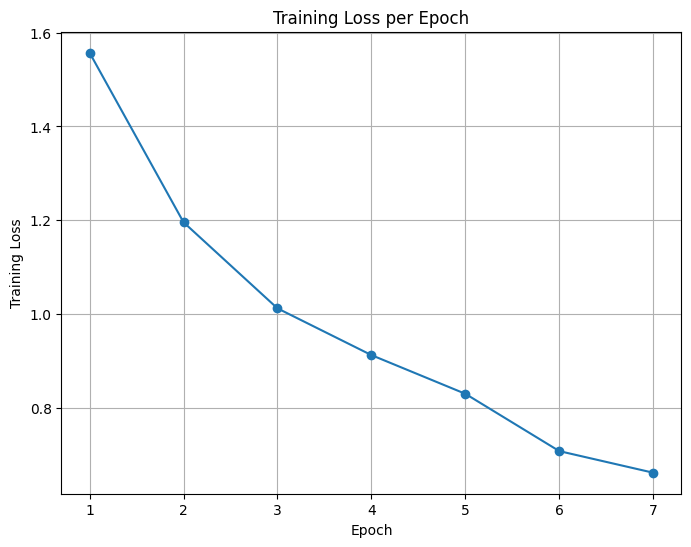

Test Accuracy on CIFAR-10: 76.26%


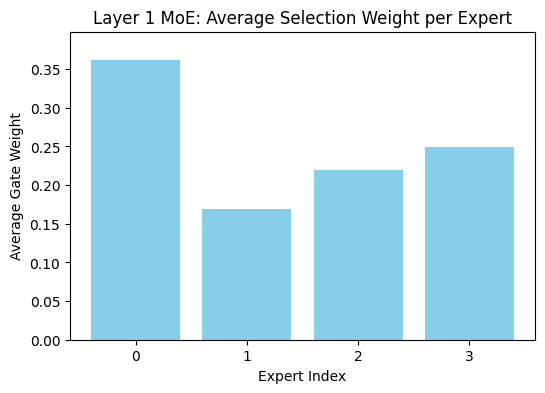

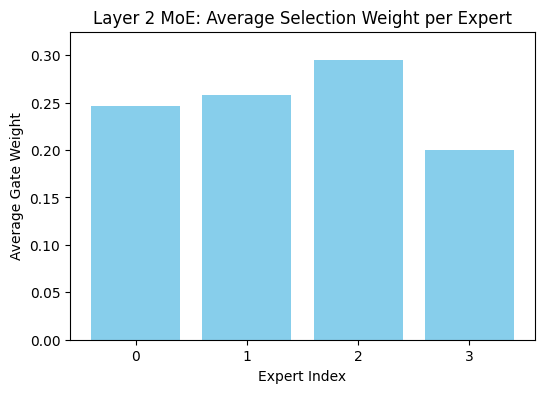

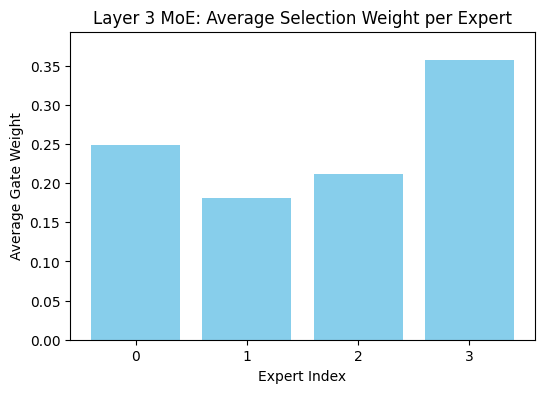

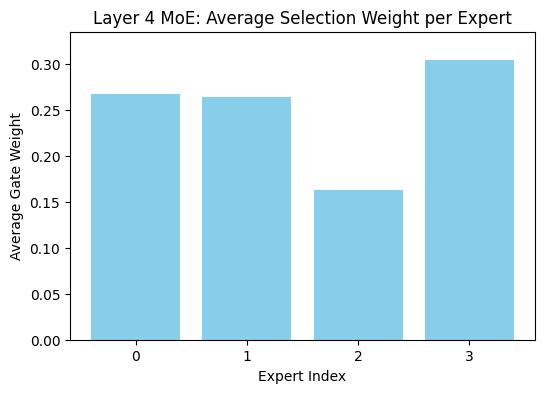

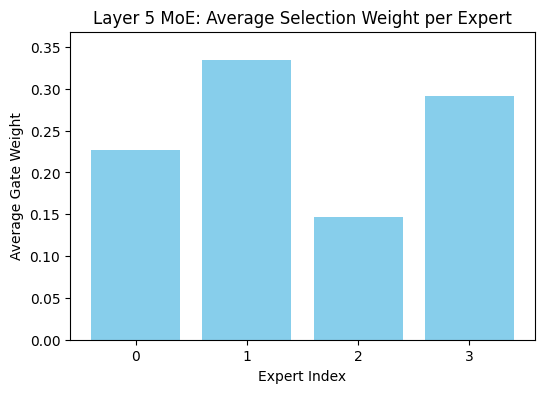

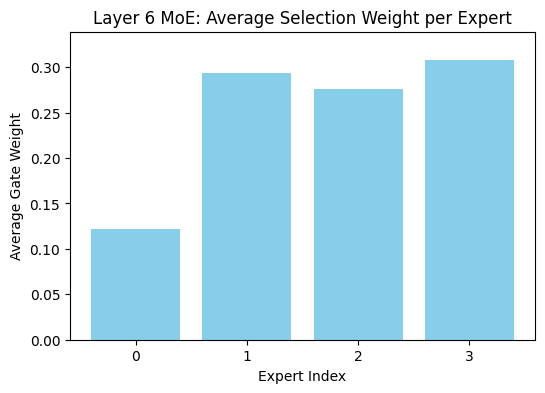

Epoch [8] Batch [10/391] Loss: 0.6968
Epoch [8] Batch [20/391] Loss: 0.7303
Epoch [8] Batch [30/391] Loss: 0.5578
Epoch [8] Batch [40/391] Loss: 0.6755
Epoch [8] Batch [50/391] Loss: 0.5796
Epoch [8] Batch [60/391] Loss: 0.5813
Epoch [8] Batch [70/391] Loss: 0.5931
Epoch [8] Batch [80/391] Loss: 0.5702
Epoch [8] Batch [90/391] Loss: 0.6977
Epoch [8] Batch [100/391] Loss: 0.7946
Epoch [8] Batch [110/391] Loss: 0.7201
Epoch [8] Batch [120/391] Loss: 0.6855
Epoch [8] Batch [130/391] Loss: 0.8409
Epoch [8] Batch [140/391] Loss: 0.5399
Epoch [8] Batch [150/391] Loss: 0.3680
Epoch [8] Batch [160/391] Loss: 0.5921
Epoch [8] Batch [170/391] Loss: 0.8211
Epoch [8] Batch [180/391] Loss: 0.7023
Epoch [8] Batch [190/391] Loss: 0.6155
Epoch [8] Batch [200/391] Loss: 0.5147
Epoch [8] Batch [210/391] Loss: 0.5017
Epoch [8] Batch [220/391] Loss: 0.6811
Epoch [8] Batch [230/391] Loss: 0.6352
Epoch [8] Batch [240/391] Loss: 0.7264
Epoch [8] Batch [250/391] Loss: 0.7443
Epoch [8] Batch [260/391] Loss: 0.

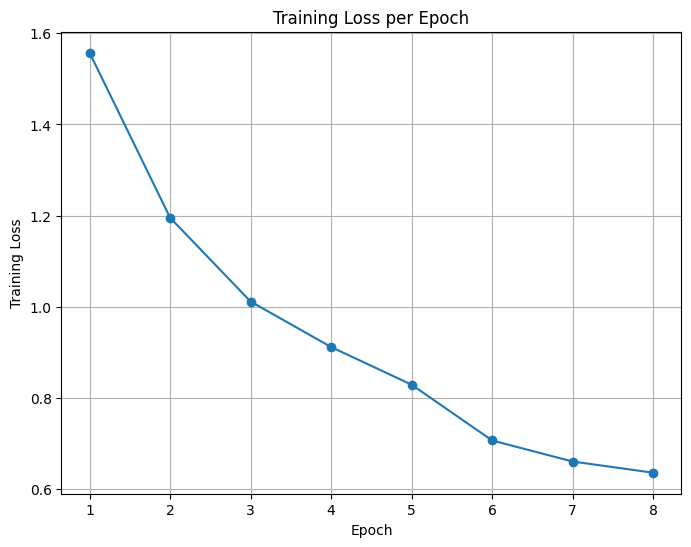

Test Accuracy on CIFAR-10: 77.59%


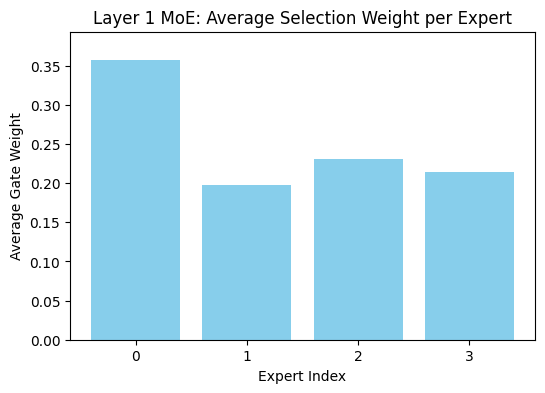

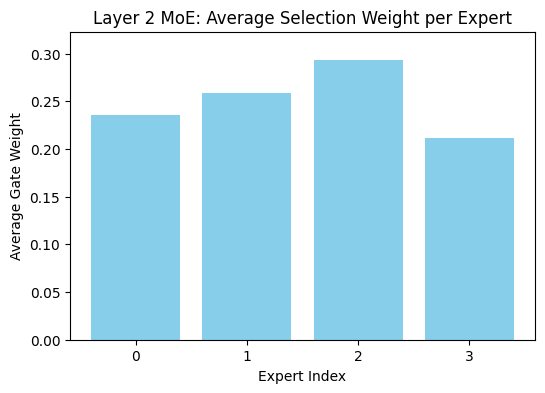

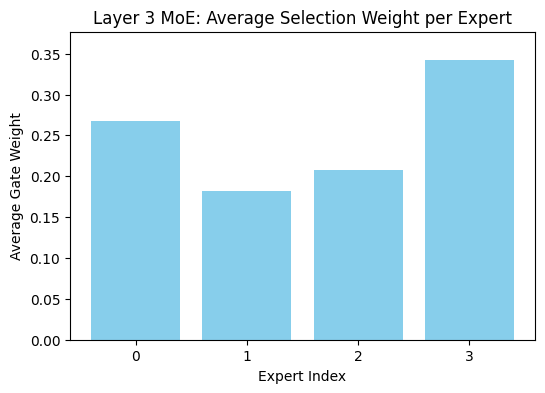

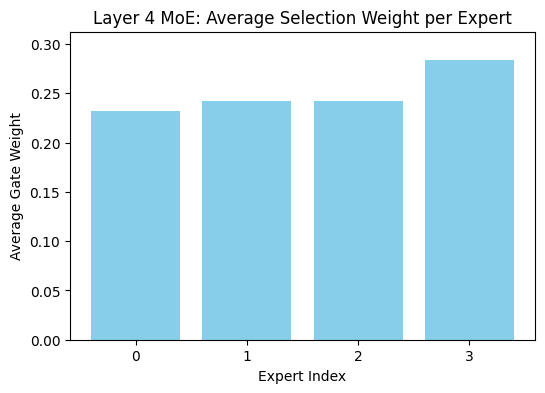

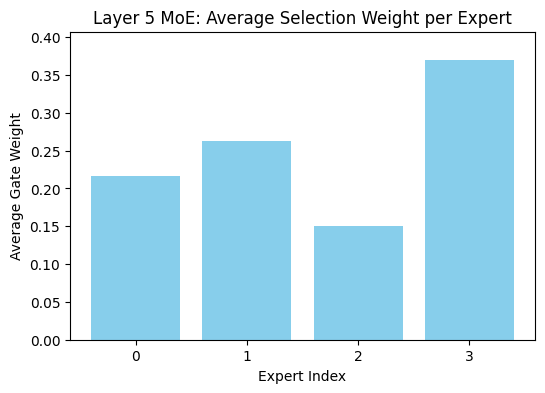

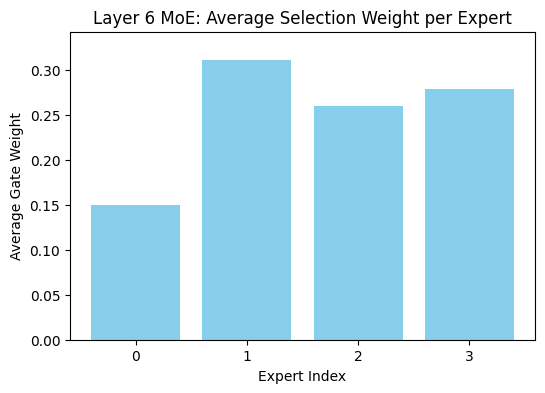

Epoch [9] Batch [10/391] Loss: 0.3769
Epoch [9] Batch [20/391] Loss: 0.6298
Epoch [9] Batch [30/391] Loss: 0.6085
Epoch [9] Batch [40/391] Loss: 0.4643
Epoch [9] Batch [50/391] Loss: 0.7601
Epoch [9] Batch [60/391] Loss: 0.6272
Epoch [9] Batch [70/391] Loss: 0.5211
Epoch [9] Batch [80/391] Loss: 0.6004
Epoch [9] Batch [90/391] Loss: 0.6671
Epoch [9] Batch [100/391] Loss: 0.6592
Epoch [9] Batch [110/391] Loss: 0.6428
Epoch [9] Batch [120/391] Loss: 0.6521
Epoch [9] Batch [130/391] Loss: 0.5691
Epoch [9] Batch [140/391] Loss: 0.7089
Epoch [9] Batch [150/391] Loss: 0.5207
Epoch [9] Batch [160/391] Loss: 0.5180
Epoch [9] Batch [170/391] Loss: 0.6826
Epoch [9] Batch [180/391] Loss: 0.7025
Epoch [9] Batch [190/391] Loss: 0.6406
Epoch [9] Batch [200/391] Loss: 0.7582
Epoch [9] Batch [210/391] Loss: 0.4365
Epoch [9] Batch [220/391] Loss: 0.5908
Epoch [9] Batch [230/391] Loss: 0.5923
Epoch [9] Batch [240/391] Loss: 0.6317
Epoch [9] Batch [250/391] Loss: 0.5633
Epoch [9] Batch [260/391] Loss: 0.

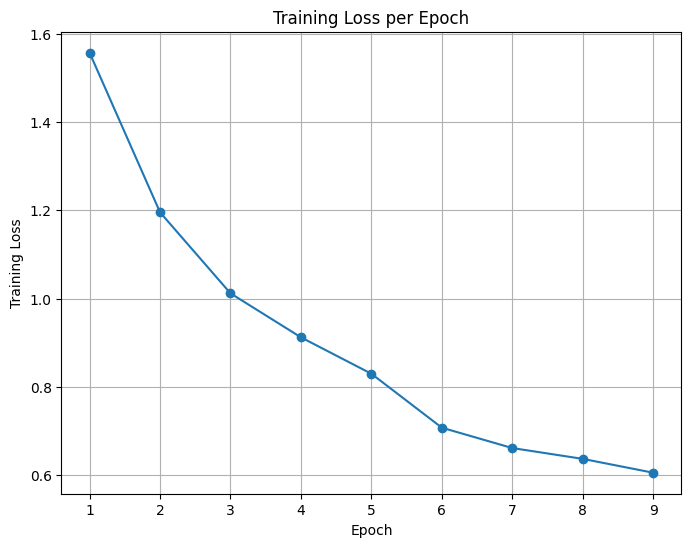

Test Accuracy on CIFAR-10: 76.22%


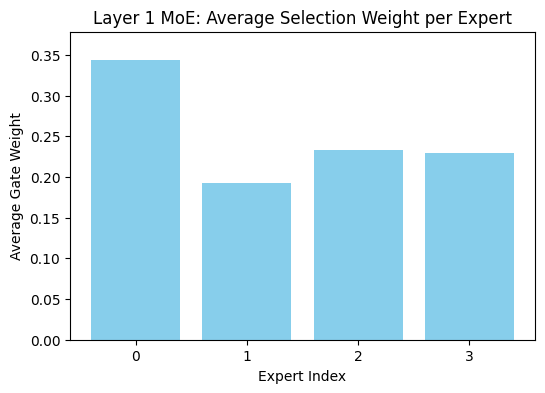

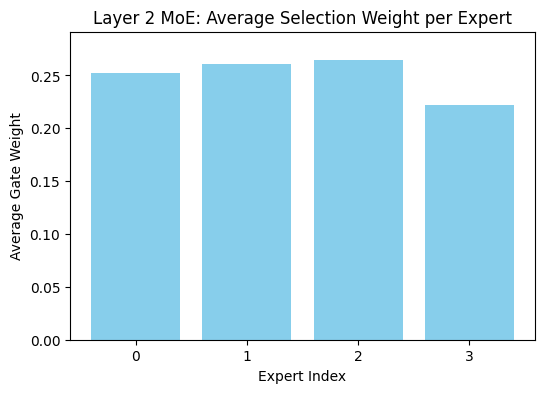

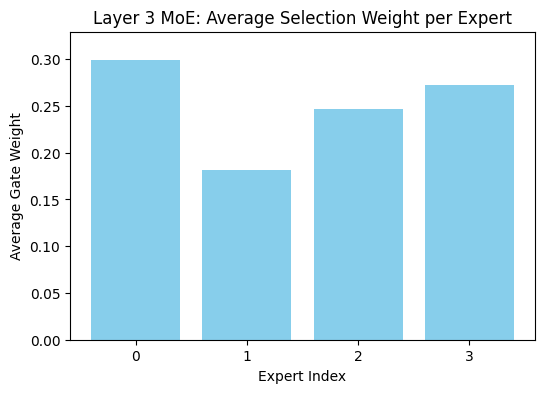

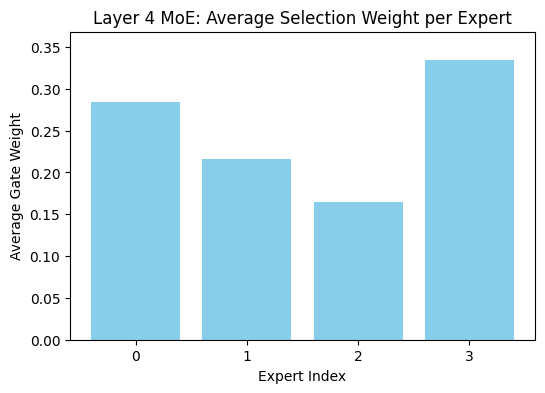

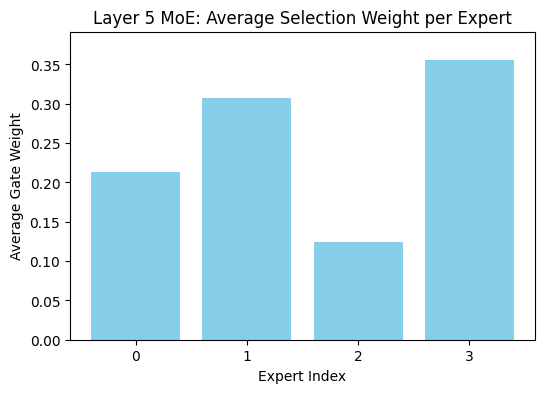

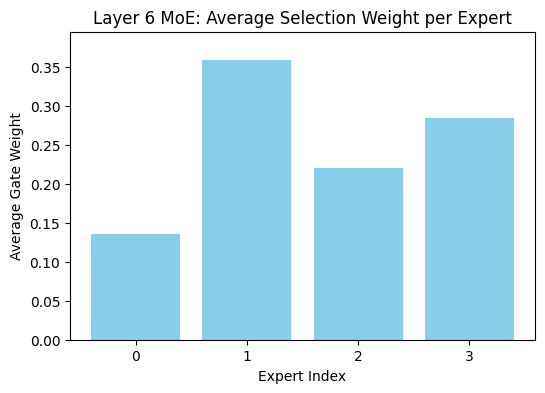

Epoch [10] Batch [10/391] Loss: 0.6133
Epoch [10] Batch [20/391] Loss: 0.4004
Epoch [10] Batch [30/391] Loss: 0.6126
Epoch [10] Batch [40/391] Loss: 0.7033
Epoch [10] Batch [50/391] Loss: 0.6299
Epoch [10] Batch [60/391] Loss: 0.5436
Epoch [10] Batch [70/391] Loss: 0.5569
Epoch [10] Batch [80/391] Loss: 0.6220
Epoch [10] Batch [90/391] Loss: 0.4474
Epoch [10] Batch [100/391] Loss: 0.5949
Epoch [10] Batch [110/391] Loss: 0.5500
Epoch [10] Batch [120/391] Loss: 0.4759
Epoch [10] Batch [130/391] Loss: 0.6168
Epoch [10] Batch [140/391] Loss: 0.4788
Epoch [10] Batch [150/391] Loss: 0.3686
Epoch [10] Batch [160/391] Loss: 0.7109
Epoch [10] Batch [170/391] Loss: 0.5396
Epoch [10] Batch [180/391] Loss: 0.5649
Epoch [10] Batch [190/391] Loss: 0.6244
Epoch [10] Batch [200/391] Loss: 0.4248
Epoch [10] Batch [210/391] Loss: 0.6539
Epoch [10] Batch [220/391] Loss: 0.5494
Epoch [10] Batch [230/391] Loss: 0.4445
Epoch [10] Batch [240/391] Loss: 0.5405
Epoch [10] Batch [250/391] Loss: 0.4363
Epoch [10

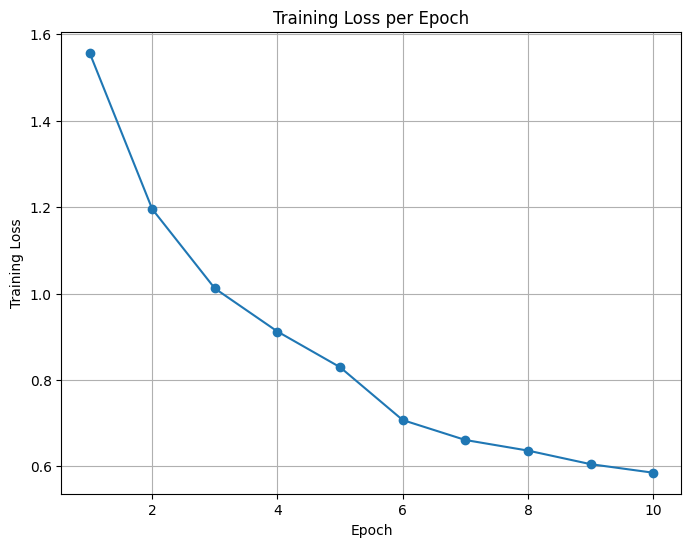

Test Accuracy on CIFAR-10: 78.84%


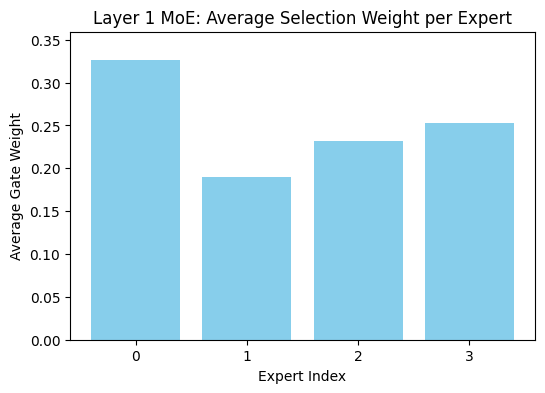

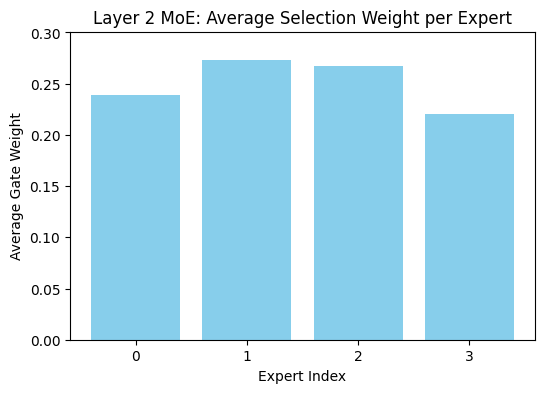

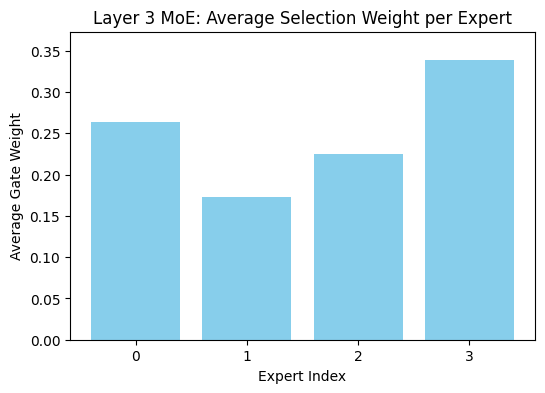

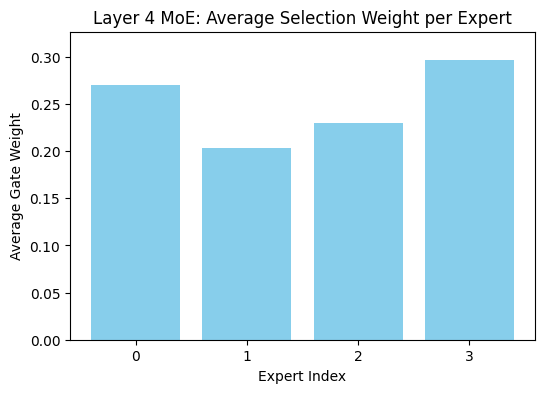

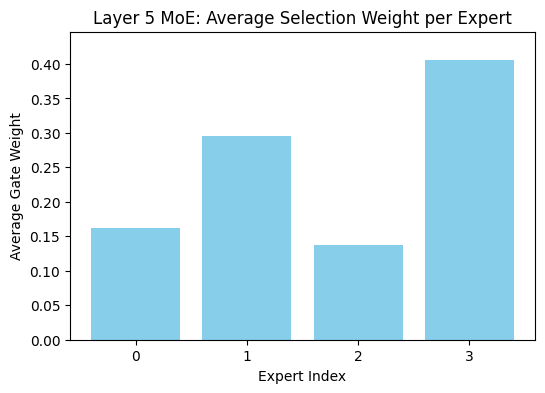

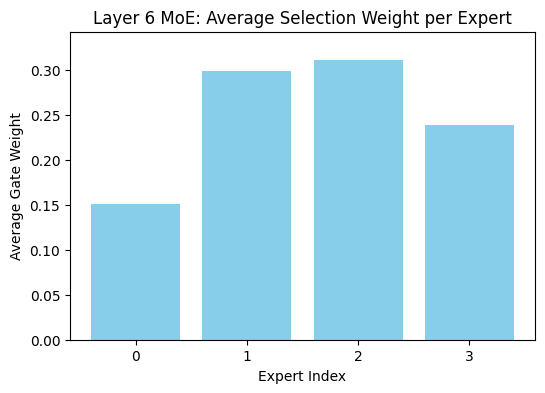

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# Expert Module
# -------------------------------
class Expert(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Expert, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        return F.relu(self.bn(self.conv(x)))

# -------------------------------
# Gating Network
# -------------------------------
class GatingNetwork(nn.Module):
    def __init__(self, in_channels, num_experts):
        super(GatingNetwork, self).__init__()
        self.gap = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling.
        self.fc = nn.Linear(in_channels, num_experts)

    def forward(self, x):
        out = self.gap(x).squeeze(-1).squeeze(-1)  # shape: [batch, in_channels]
        gate_logits = self.fc(out)
        gate_weights = F.softmax(gate_logits, dim=-1)
        return gate_weights

# -------------------------------
# MoE Block
# -------------------------------
class MoEBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_experts=4):
        super(MoEBlock, self).__init__()
        self.num_experts = num_experts
        self.experts = nn.ModuleList(
            [Expert(in_channels, out_channels) for _ in range(num_experts)]
        )
        self.gate = GatingNetwork(in_channels, num_experts)
        self.out_conv = nn.Conv2d(out_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x, return_gate=False):
        gate_weights = self.gate(x)  # [batch, num_experts]
        expert_outputs = [expert(x) for expert in self.experts]
        # Stack expert outputs: shape [batch, num_experts, out_channels, H, W]
        expert_stack = torch.stack(expert_outputs, dim=1)
        # Reshape gate weights for elementwise multiplication. New shape: [batch, num_experts, 1, 1, 1]
        gate_weights_expanded = gate_weights.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        # Aggregate expert outputs using the gating weights.
        out = (expert_stack * gate_weights_expanded).sum(dim=1)
        out = self.out_conv(out)
        out = self.bn(out)
        out = F.relu(out)
        if return_gate:
            return out, gate_weights
        return out

# -------------------------------
# Downsample Block (Pooling + 1x1 Conv)
# -------------------------------
class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Downsample, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x)

# -------------------------------
# DeepMoE Model Definition
# -------------------------------
class DeepMoEModel(nn.Module):
    def __init__(self, input_channels=3, base_channels=64, num_experts=4, num_classes=10):
        super(DeepMoEModel, self).__init__()

        # Initial convolution block.
        self.initial = nn.Sequential(
            nn.Conv2d(input_channels, base_channels, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.stages = nn.ModuleList()
        current_channels = base_channels

        # Stage 1: Two MoEBlocks.
        stage1 = nn.Sequential(
            MoEBlock(current_channels, current_channels, num_experts),
            MoEBlock(current_channels, current_channels, num_experts)
        )
        self.stages.append(stage1)

        # Downsample stage: adjust channels for next stage.
        next_channels = current_channels * 2
        self.downsample1 = Downsample(current_channels, next_channels)
        current_channels = next_channels

        # Stage 2: Two MoEBlocks.
        stage2 = nn.Sequential(
            MoEBlock(current_channels, current_channels, num_experts),
            MoEBlock(current_channels, current_channels, num_experts)
        )
        self.stages.append(stage2)

        # Downsample stage.
        next_channels = current_channels * 2
        self.downsample2 = Downsample(current_channels, next_channels)
        current_channels = next_channels

        # Stage 3: Two MoEBlocks.
        stage3 = nn.Sequential(
            MoEBlock(current_channels, current_channels, num_experts),
            MoEBlock(current_channels, current_channels, num_experts)
        )
        self.stages.append(stage3)

        # Global Average Pooling and final classifier.
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(current_channels, num_classes)  # for CIFAR-10, num_classes = 10

    def forward(self, x, return_gate=False):
        x = self.initial(x)
        gate_outputs = []

        # Stage 1:
        for block in self.stages[0]:
            if isinstance(block, MoEBlock):
                if return_gate:
                    x, gate = block(x, return_gate=True)
                    gate_outputs.append(gate)
                else:
                    x = block(x)
            else:
                x = block(x)

        # Downsample after stage 1.
        x = self.downsample1(x)

        # Stage 2:
        for block in self.stages[1]:
            if isinstance(block, MoEBlock):
                if return_gate:
                    x, gate = block(x, return_gate=True)
                    gate_outputs.append(gate)
                else:
                    x = block(x)
            else:
                x = block(x)

        # Downsample after stage 2.
        x = self.downsample2(x)

        # Stage 3:
        for block in self.stages[2]:
            if isinstance(block, MoEBlock):
                if return_gate:
                    x, gate = block(x, return_gate=True)
                    gate_outputs.append(gate)
                else:
                    x = block(x)
            else:
                x = block(x)

        x = self.gap(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)

        if return_gate:
            return logits, gate_outputs
        return logits

# -------------------------------
# Evaluation function: Compute gating statistics
# -------------------------------
def evaluate_gating(model, device, test_loader):
    model.eval()
    gating_stats_list = []
    sample_count = 0

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            batch_size = data.size(0)
            sample_count += batch_size

            # Forward pass with gating outputs.
            _, gate_outputs = model(data, return_gate=True)

            for i, gate in enumerate(gate_outputs):
                if len(gating_stats_list) <= i:
                    gating_stats_list.append(gate.sum(dim=0))
                else:
                    gating_stats_list[i] += gate.sum(dim=0)

    gating_stats_list = [stats / sample_count for stats in gating_stats_list]
    return gating_stats_list

# -------------------------------
# Plotting function: Plot gating statistics
# -------------------------------
def plot_gating_statistics(gating_stats_list):
    for i, stats in enumerate(gating_stats_list):
        experts = np.arange(len(stats))
        stats_np = stats.cpu().numpy() if hasattr(stats, 'cpu') else stats
        plt.figure(figsize=(6,4))
        plt.bar(experts, stats_np, color='skyblue')
        plt.xlabel('Expert Index')
        plt.ylabel('Average Gate Weight')
        plt.title(f'Layer {i+1} MoE: Average Selection Weight per Expert')
        plt.xticks(experts)
        plt.ylim(0, np.max(stats_np) * 1.1)
        plt.show()

# -------------------------------
# Training Loop
# -------------------------------
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"Epoch [{epoch}] Batch [{batch_idx+1}/{len(train_loader)}] Loss: {loss.item():.4f}")

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch}] Average Loss: {avg_loss:.4f}")
    return avg_loss

# -------------------------------
# Main: Dataset Preparation, Training, Evaluation, and Plotting
# -------------------------------
# Hyperparameters
num_epochs = 10
batch_size = 128
learning_rate = 0.001

# Define CIFAR-10 transforms with data augmentation for training.
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                          std=[0.2470, 0.2435, 0.2616]),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                          std=[0.2470, 0.2435, 0.2616]),
])

# Load CIFAR-10 training and test datasets.
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, loss criterion, optimizer, and learning rate scheduler.
model = DeepMoEModel(input_channels=3, base_channels=64, num_experts=4, num_classes=10)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# List to store training losses.
train_losses = []

print("Starting training on CIFAR-10...")
for epoch in range(1, num_epochs + 1):
    loss = train(model, device, train_loader, optimizer, criterion, epoch)
    train_losses.append(loss)
    scheduler.step()  # Step the scheduler.

    # Plot training loss over epochs.
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epoch + 1), train_losses, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss per Epoch')
    plt.grid(True)
    plt.show()

    # Evaluate model on test dataset.
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    accuracy = 100. * correct / total
    print(f"Test Accuracy on CIFAR-10: {accuracy:.2f}%")

    # Evaluate gating statistics and plot them.
    gating_stats = evaluate_gating(model, device, test_loader)
    plot_gating_statistics(gating_stats)




range(1, 11)

Files already downloaded and verified
Files already downloaded and verified
Starting training on CIFAR-10 with Top-2 Expert Selection...
Epoch [1] Batch [10/391] Loss: 2.2004
Epoch [1] Batch [20/391] Loss: 2.0003
Epoch [1] Batch [30/391] Loss: 1.8422
Epoch [1] Batch [40/391] Loss: 1.9133
Epoch [1] Batch [50/391] Loss: 1.7624
Epoch [1] Batch [60/391] Loss: 1.5772
Epoch [1] Batch [70/391] Loss: 1.7639
Epoch [1] Batch [80/391] Loss: 1.6343
Epoch [1] Batch [90/391] Loss: 1.6670
Epoch [1] Batch [100/391] Loss: 1.5538
Epoch [1] Batch [110/391] Loss: 1.5608
Epoch [1] Batch [120/391] Loss: 1.4790
Epoch [1] Batch [130/391] Loss: 1.7212
Epoch [1] Batch [140/391] Loss: 1.6244
Epoch [1] Batch [150/391] Loss: 1.4838
Epoch [1] Batch [160/391] Loss: 1.6309
Epoch [1] Batch [170/391] Loss: 1.5455
Epoch [1] Batch [180/391] Loss: 1.6689
Epoch [1] Batch [190/391] Loss: 1.6458
Epoch [1] Batch [200/391] Loss: 1.4737
Epoch [1] Batch [210/391] Loss: 1.8414
Epoch [1] Batch [220/391] Loss: 1.5731
Epoch [1] Batc

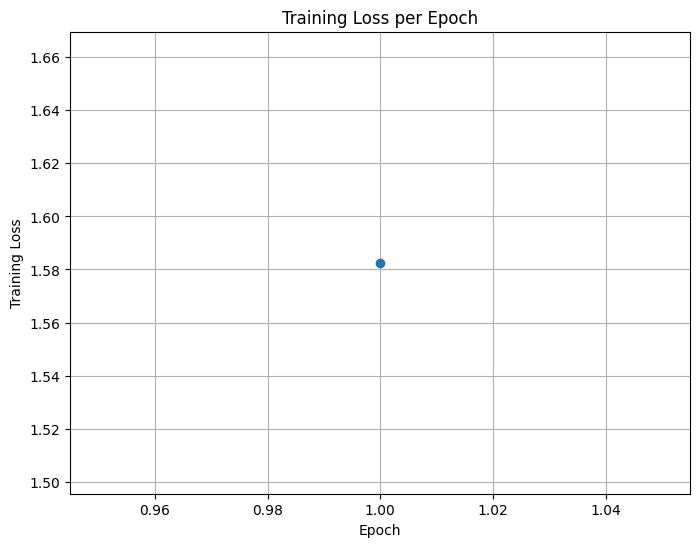

Test Accuracy on CIFAR-10: 50.95%


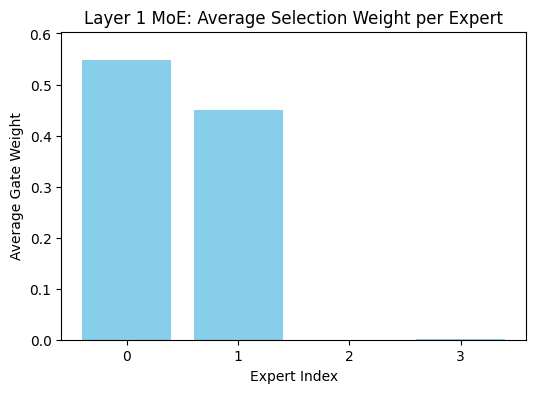

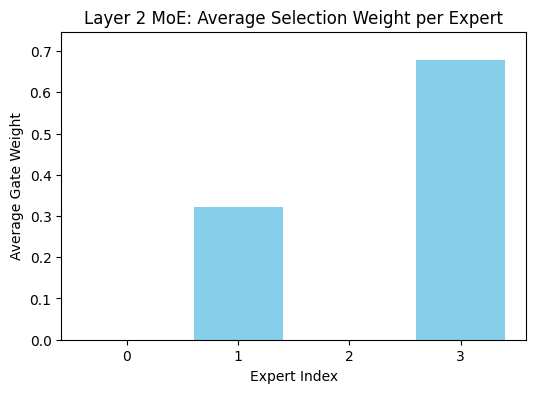

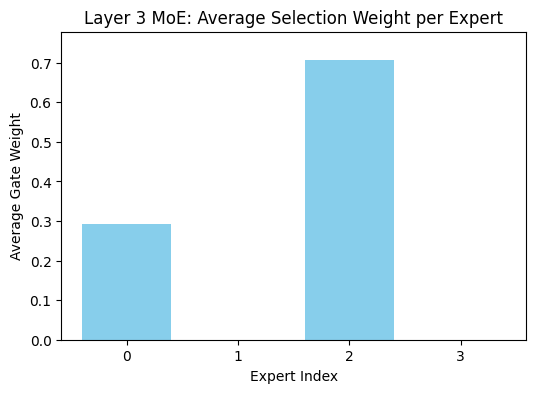

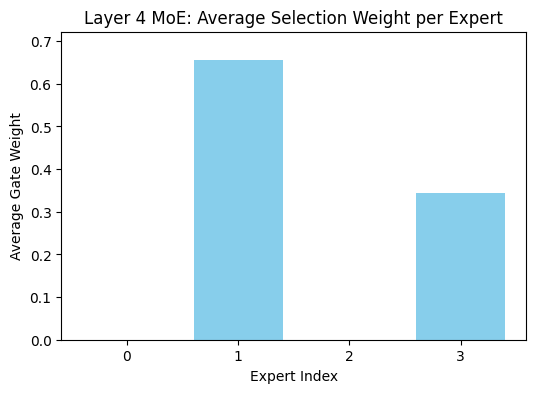

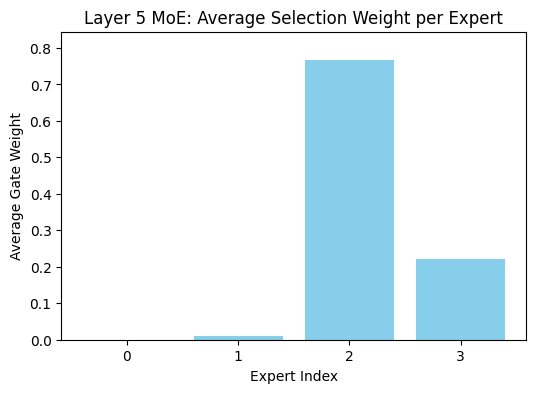

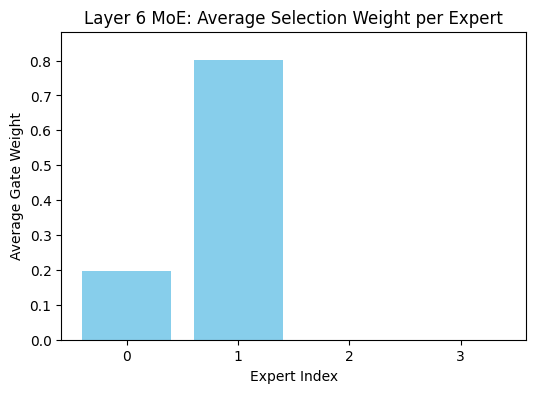

Epoch [2] Batch [10/391] Loss: 1.2987
Epoch [2] Batch [20/391] Loss: 1.3191
Epoch [2] Batch [30/391] Loss: 1.3153
Epoch [2] Batch [40/391] Loss: 1.1887
Epoch [2] Batch [50/391] Loss: 1.4193
Epoch [2] Batch [60/391] Loss: 1.3581
Epoch [2] Batch [70/391] Loss: 1.3232
Epoch [2] Batch [80/391] Loss: 1.2006
Epoch [2] Batch [90/391] Loss: 1.2767
Epoch [2] Batch [100/391] Loss: 1.1548
Epoch [2] Batch [110/391] Loss: 1.3744
Epoch [2] Batch [120/391] Loss: 1.0993
Epoch [2] Batch [130/391] Loss: 1.1645
Epoch [2] Batch [140/391] Loss: 1.2777
Epoch [2] Batch [150/391] Loss: 1.1454
Epoch [2] Batch [160/391] Loss: 1.4574
Epoch [2] Batch [170/391] Loss: 1.2489
Epoch [2] Batch [180/391] Loss: 1.2052
Epoch [2] Batch [190/391] Loss: 1.2580
Epoch [2] Batch [200/391] Loss: 1.1745
Epoch [2] Batch [210/391] Loss: 1.2275
Epoch [2] Batch [220/391] Loss: 1.0612
Epoch [2] Batch [230/391] Loss: 1.1656
Epoch [2] Batch [240/391] Loss: 1.1615
Epoch [2] Batch [250/391] Loss: 1.2199
Epoch [2] Batch [260/391] Loss: 1.

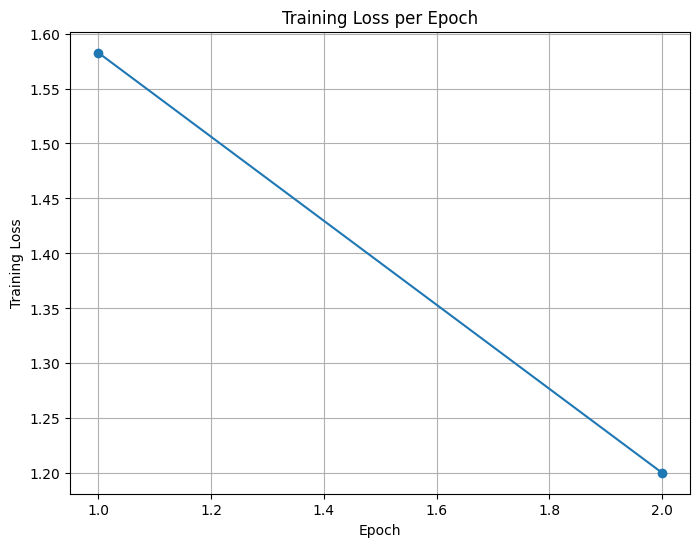

Test Accuracy on CIFAR-10: 58.03%


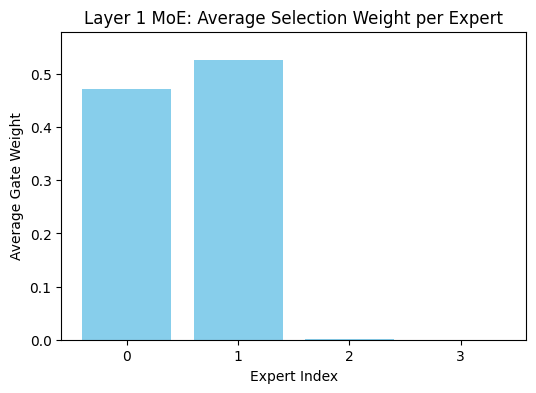

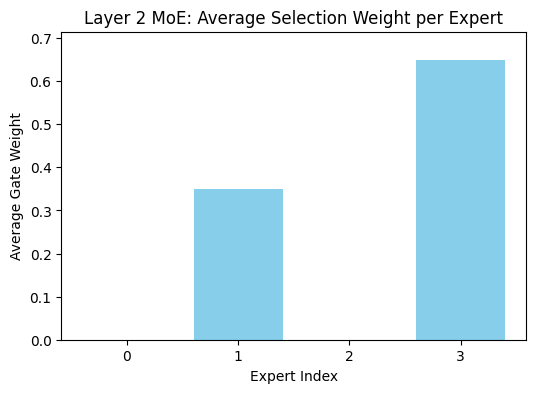

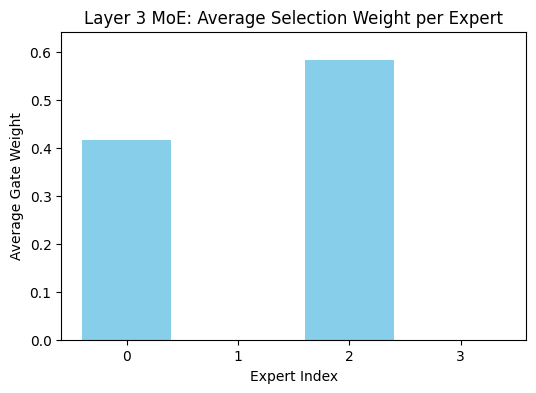

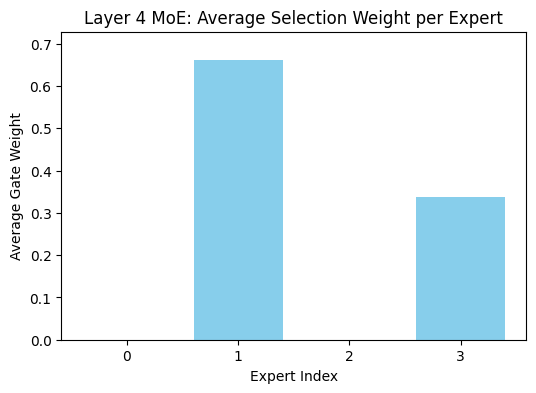

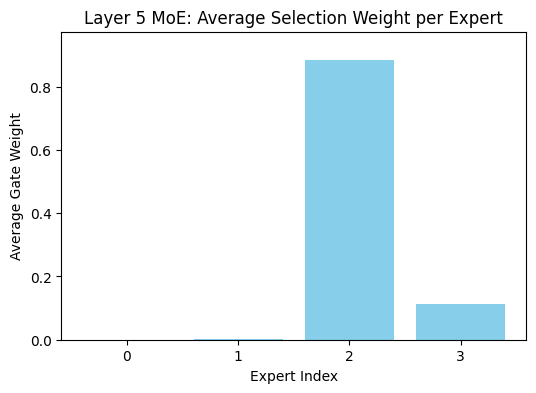

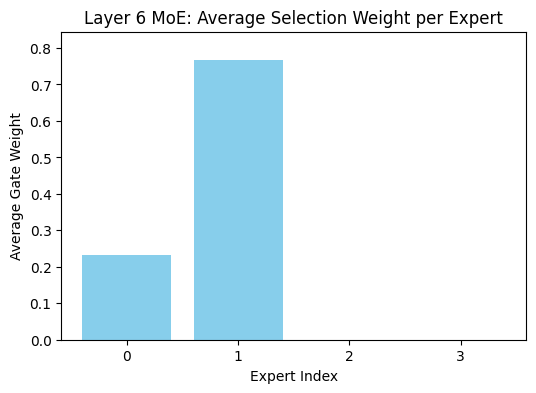

Epoch [3] Batch [10/391] Loss: 1.0350
Epoch [3] Batch [20/391] Loss: 1.1229
Epoch [3] Batch [30/391] Loss: 1.1898
Epoch [3] Batch [40/391] Loss: 0.9041
Epoch [3] Batch [50/391] Loss: 1.0911
Epoch [3] Batch [60/391] Loss: 1.1370
Epoch [3] Batch [70/391] Loss: 1.0872
Epoch [3] Batch [80/391] Loss: 1.0214
Epoch [3] Batch [90/391] Loss: 0.9889
Epoch [3] Batch [100/391] Loss: 1.0711
Epoch [3] Batch [110/391] Loss: 0.9760
Epoch [3] Batch [120/391] Loss: 0.8667
Epoch [3] Batch [130/391] Loss: 1.0456
Epoch [3] Batch [140/391] Loss: 1.1533
Epoch [3] Batch [150/391] Loss: 0.9601
Epoch [3] Batch [160/391] Loss: 1.0763
Epoch [3] Batch [170/391] Loss: 1.1033
Epoch [3] Batch [180/391] Loss: 1.0063
Epoch [3] Batch [190/391] Loss: 1.1025
Epoch [3] Batch [200/391] Loss: 1.0733
Epoch [3] Batch [210/391] Loss: 0.9820
Epoch [3] Batch [220/391] Loss: 1.0410
Epoch [3] Batch [230/391] Loss: 1.0318
Epoch [3] Batch [240/391] Loss: 0.9730
Epoch [3] Batch [250/391] Loss: 1.0609
Epoch [3] Batch [260/391] Loss: 0.

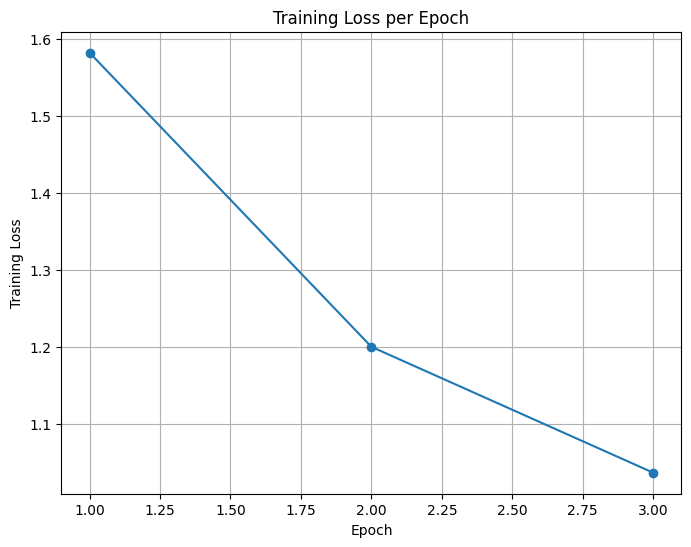

Test Accuracy on CIFAR-10: 62.82%


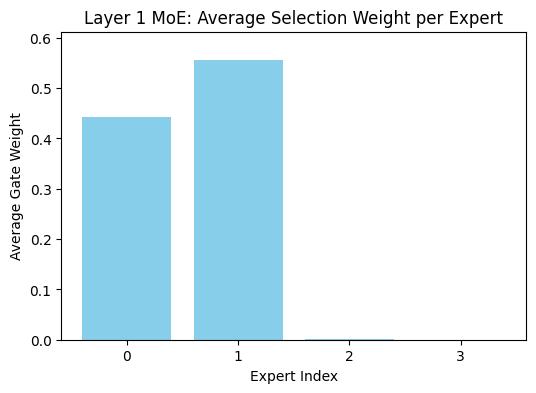

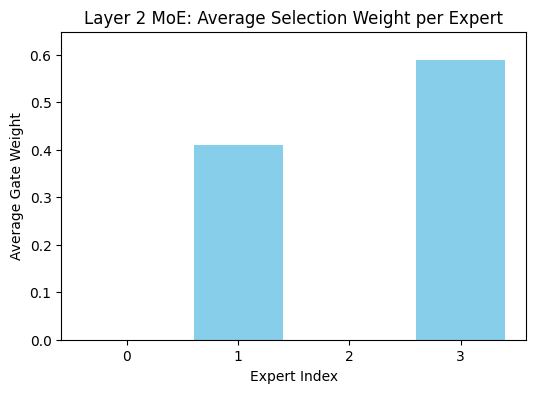

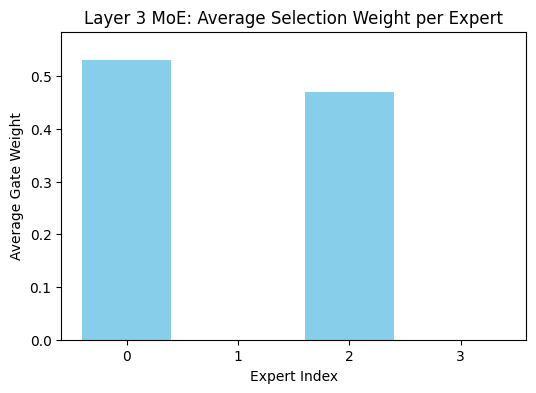

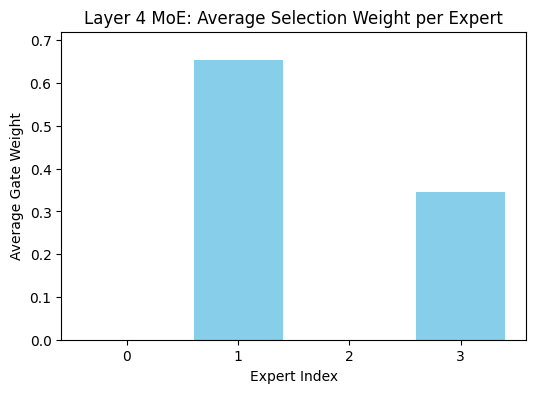

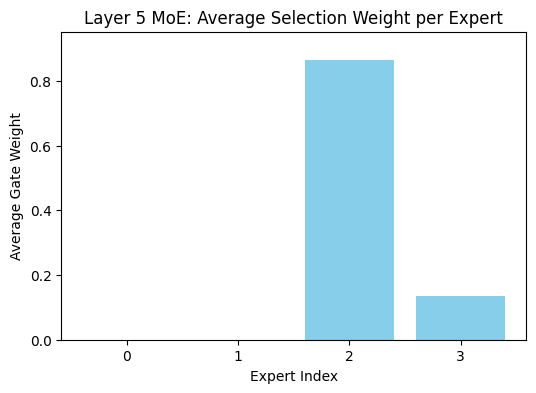

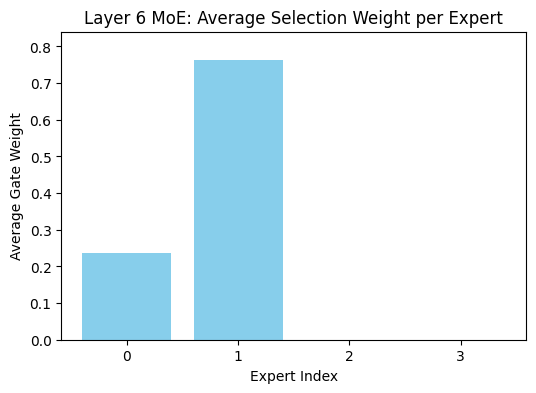

Epoch [4] Batch [10/391] Loss: 0.9197
Epoch [4] Batch [20/391] Loss: 0.8986
Epoch [4] Batch [30/391] Loss: 0.9621
Epoch [4] Batch [40/391] Loss: 1.0834
Epoch [4] Batch [50/391] Loss: 0.8301
Epoch [4] Batch [60/391] Loss: 1.1608
Epoch [4] Batch [70/391] Loss: 0.9755
Epoch [4] Batch [80/391] Loss: 1.2053
Epoch [4] Batch [90/391] Loss: 0.8355
Epoch [4] Batch [100/391] Loss: 1.0719
Epoch [4] Batch [110/391] Loss: 0.8802
Epoch [4] Batch [120/391] Loss: 1.0128
Epoch [4] Batch [130/391] Loss: 0.8517
Epoch [4] Batch [140/391] Loss: 0.9305
Epoch [4] Batch [150/391] Loss: 0.9076
Epoch [4] Batch [160/391] Loss: 0.7937
Epoch [4] Batch [170/391] Loss: 1.0833
Epoch [4] Batch [180/391] Loss: 1.1222
Epoch [4] Batch [190/391] Loss: 1.0540
Epoch [4] Batch [200/391] Loss: 0.8550
Epoch [4] Batch [210/391] Loss: 0.9075
Epoch [4] Batch [220/391] Loss: 0.9578
Epoch [4] Batch [230/391] Loss: 1.0122
Epoch [4] Batch [240/391] Loss: 0.8925
Epoch [4] Batch [250/391] Loss: 0.9143
Epoch [4] Batch [260/391] Loss: 0.

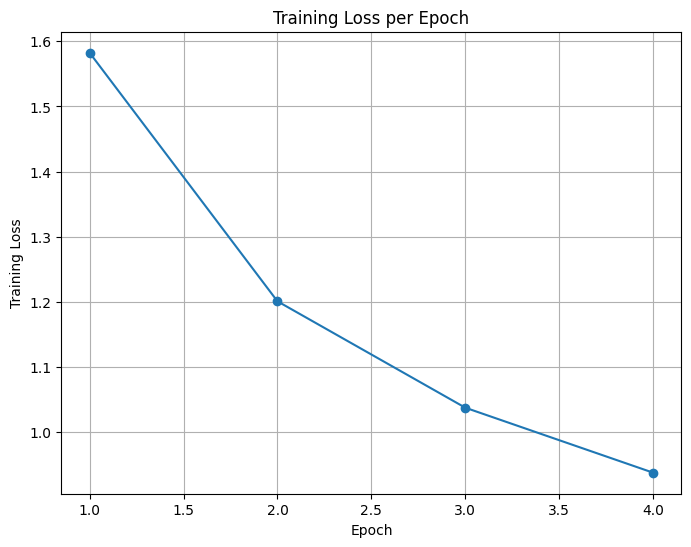

Test Accuracy on CIFAR-10: 66.00%


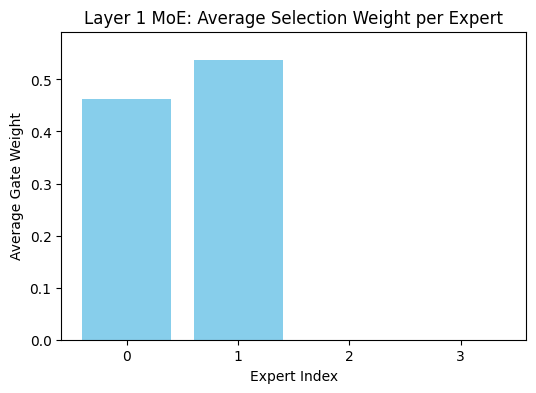

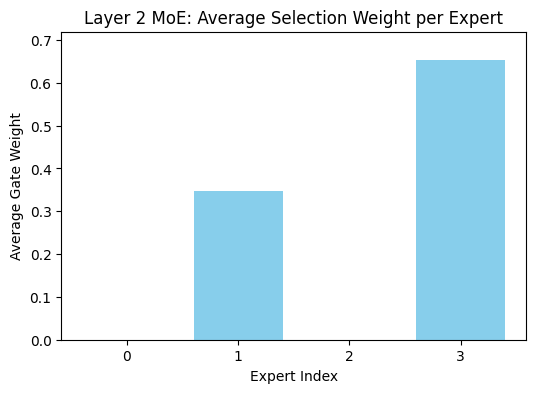

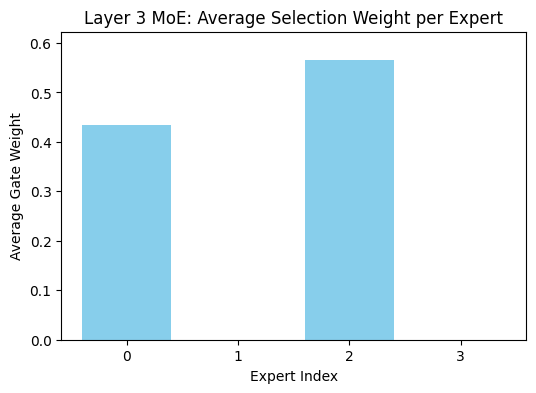

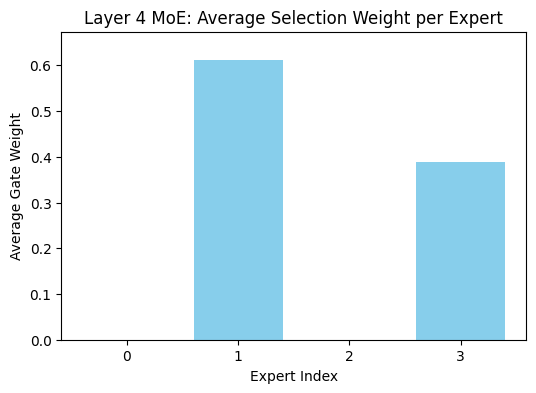

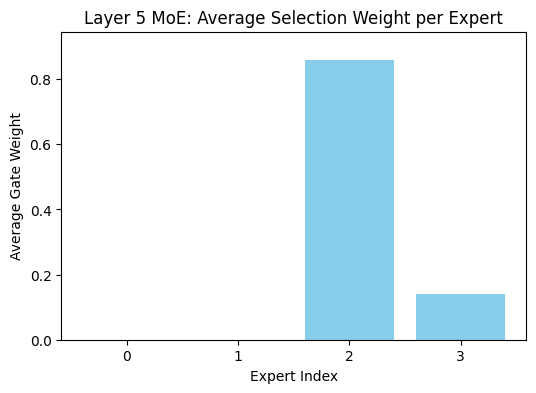

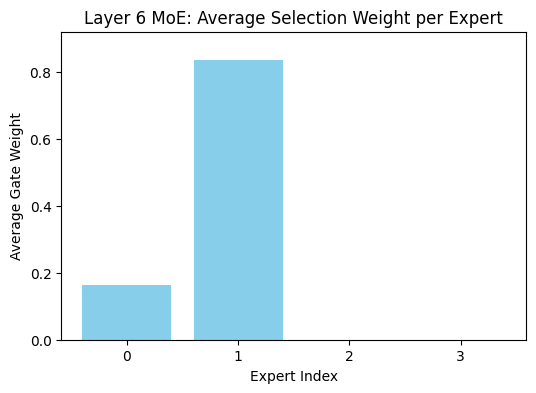

Epoch [5] Batch [10/391] Loss: 0.7253
Epoch [5] Batch [20/391] Loss: 0.8660
Epoch [5] Batch [30/391] Loss: 0.9186
Epoch [5] Batch [40/391] Loss: 0.8416
Epoch [5] Batch [50/391] Loss: 0.8435
Epoch [5] Batch [60/391] Loss: 0.8589
Epoch [5] Batch [70/391] Loss: 0.8896
Epoch [5] Batch [80/391] Loss: 0.8153
Epoch [5] Batch [90/391] Loss: 1.0690
Epoch [5] Batch [100/391] Loss: 0.7354
Epoch [5] Batch [110/391] Loss: 0.8930
Epoch [5] Batch [120/391] Loss: 0.8339
Epoch [5] Batch [130/391] Loss: 0.8642
Epoch [5] Batch [140/391] Loss: 0.8861
Epoch [5] Batch [150/391] Loss: 0.9096
Epoch [5] Batch [160/391] Loss: 0.9873
Epoch [5] Batch [170/391] Loss: 0.8885
Epoch [5] Batch [180/391] Loss: 0.8952
Epoch [5] Batch [190/391] Loss: 0.8121
Epoch [5] Batch [200/391] Loss: 0.7667
Epoch [5] Batch [210/391] Loss: 0.8808
Epoch [5] Batch [220/391] Loss: 0.9113
Epoch [5] Batch [230/391] Loss: 0.8705
Epoch [5] Batch [240/391] Loss: 0.9585
Epoch [5] Batch [250/391] Loss: 0.9047
Epoch [5] Batch [260/391] Loss: 0.

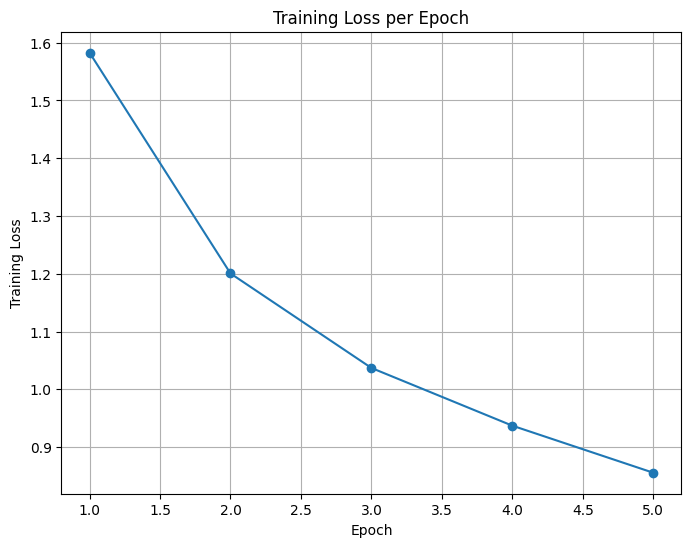

Test Accuracy on CIFAR-10: 68.80%


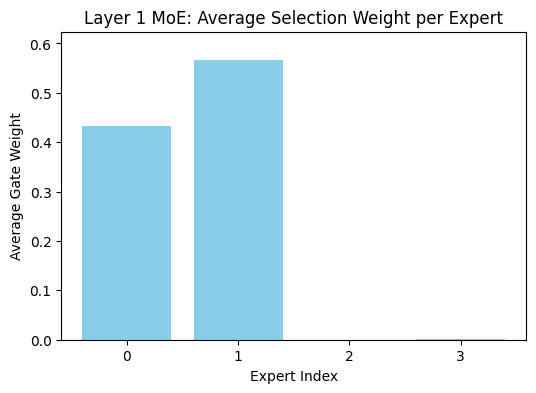

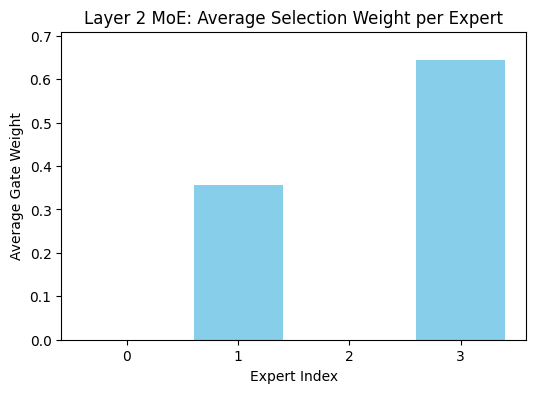

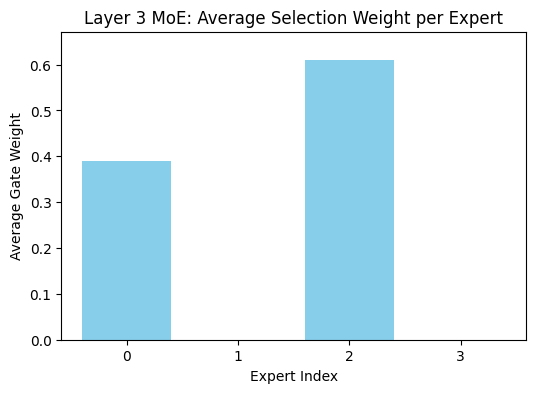

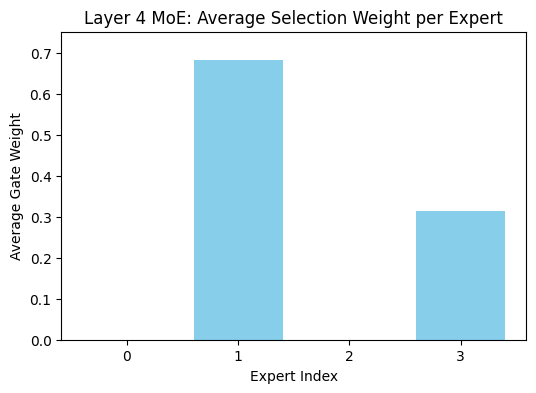

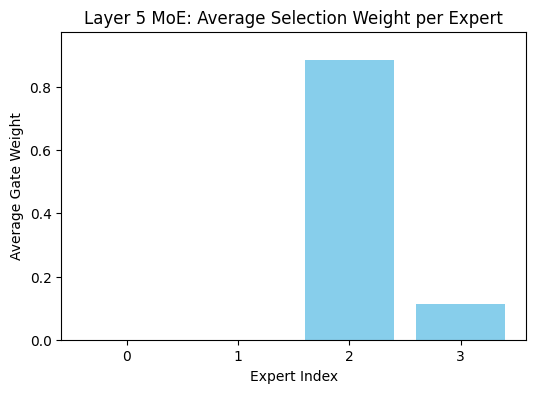

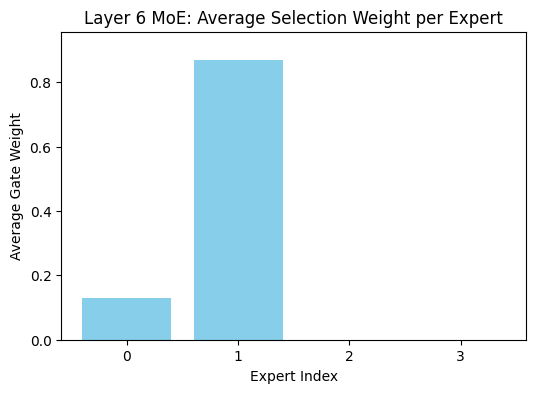

Epoch [6] Batch [10/391] Loss: 0.8808
Epoch [6] Batch [20/391] Loss: 0.7472
Epoch [6] Batch [30/391] Loss: 0.7021
Epoch [6] Batch [40/391] Loss: 0.6461
Epoch [6] Batch [50/391] Loss: 0.7199
Epoch [6] Batch [60/391] Loss: 0.8300
Epoch [6] Batch [70/391] Loss: 0.8902
Epoch [6] Batch [80/391] Loss: 0.6912
Epoch [6] Batch [90/391] Loss: 0.9134
Epoch [6] Batch [100/391] Loss: 0.6363
Epoch [6] Batch [110/391] Loss: 0.7553
Epoch [6] Batch [120/391] Loss: 0.7116
Epoch [6] Batch [130/391] Loss: 0.8094
Epoch [6] Batch [140/391] Loss: 0.7434
Epoch [6] Batch [150/391] Loss: 0.7737
Epoch [6] Batch [160/391] Loss: 0.9337
Epoch [6] Batch [170/391] Loss: 0.7483
Epoch [6] Batch [180/391] Loss: 0.6069
Epoch [6] Batch [190/391] Loss: 0.6945
Epoch [6] Batch [200/391] Loss: 0.7095
Epoch [6] Batch [210/391] Loss: 0.8510
Epoch [6] Batch [220/391] Loss: 0.7234
Epoch [6] Batch [230/391] Loss: 0.8039
Epoch [6] Batch [240/391] Loss: 0.7164
Epoch [6] Batch [250/391] Loss: 0.5923
Epoch [6] Batch [260/391] Loss: 0.

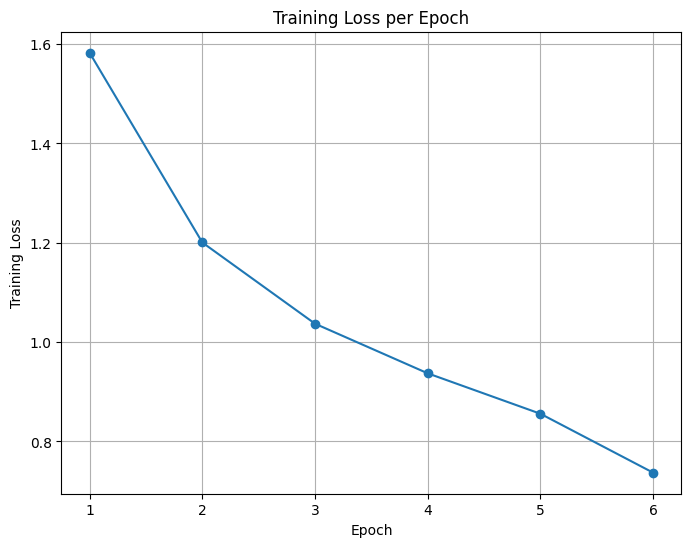

Test Accuracy on CIFAR-10: 74.20%


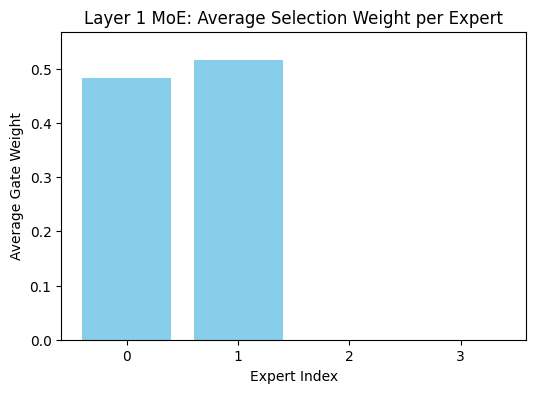

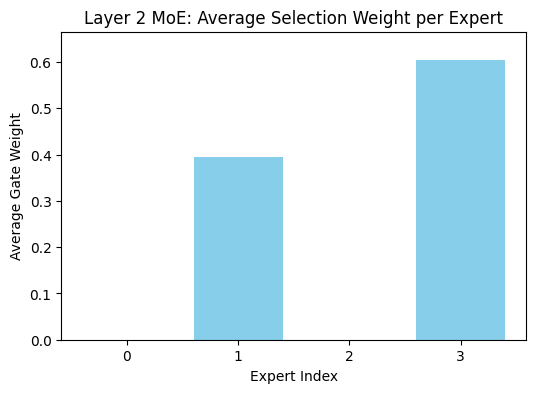

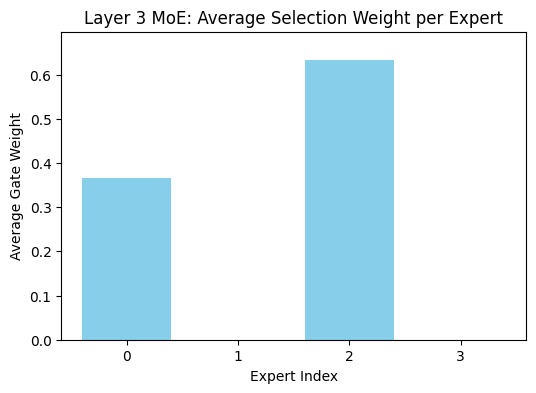

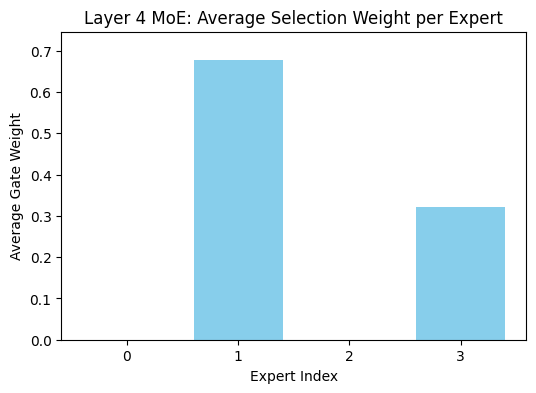

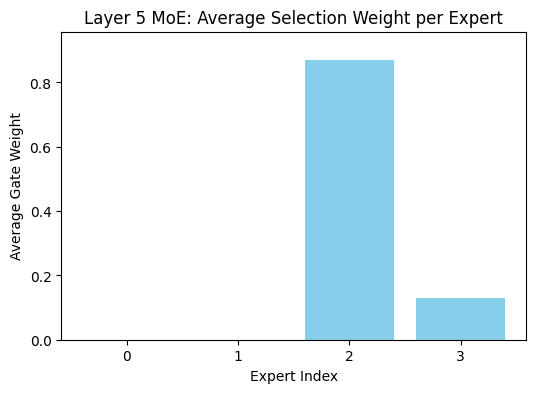

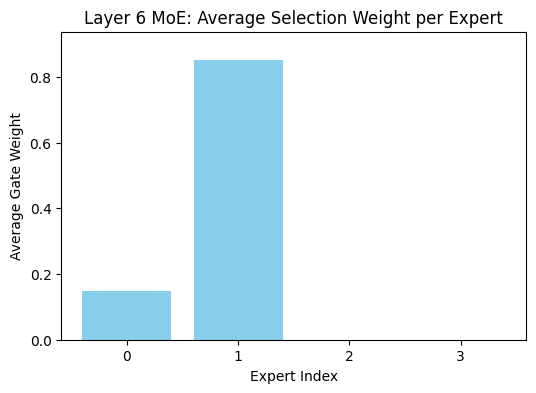

Epoch [7] Batch [10/391] Loss: 0.7352
Epoch [7] Batch [20/391] Loss: 0.6761
Epoch [7] Batch [30/391] Loss: 0.6625
Epoch [7] Batch [40/391] Loss: 0.8567
Epoch [7] Batch [50/391] Loss: 0.8143
Epoch [7] Batch [60/391] Loss: 0.7369
Epoch [7] Batch [70/391] Loss: 0.8885
Epoch [7] Batch [80/391] Loss: 0.7265
Epoch [7] Batch [90/391] Loss: 0.7342
Epoch [7] Batch [100/391] Loss: 0.5802
Epoch [7] Batch [110/391] Loss: 0.7824
Epoch [7] Batch [120/391] Loss: 0.6616
Epoch [7] Batch [130/391] Loss: 0.7283
Epoch [7] Batch [140/391] Loss: 0.5554
Epoch [7] Batch [150/391] Loss: 0.7240
Epoch [7] Batch [160/391] Loss: 0.5937
Epoch [7] Batch [170/391] Loss: 0.5851
Epoch [7] Batch [180/391] Loss: 0.6530
Epoch [7] Batch [190/391] Loss: 0.6564
Epoch [7] Batch [200/391] Loss: 0.7146
Epoch [7] Batch [210/391] Loss: 0.7343
Epoch [7] Batch [220/391] Loss: 0.6895
Epoch [7] Batch [230/391] Loss: 0.7116
Epoch [7] Batch [240/391] Loss: 0.5963
Epoch [7] Batch [250/391] Loss: 0.6114
Epoch [7] Batch [260/391] Loss: 0.

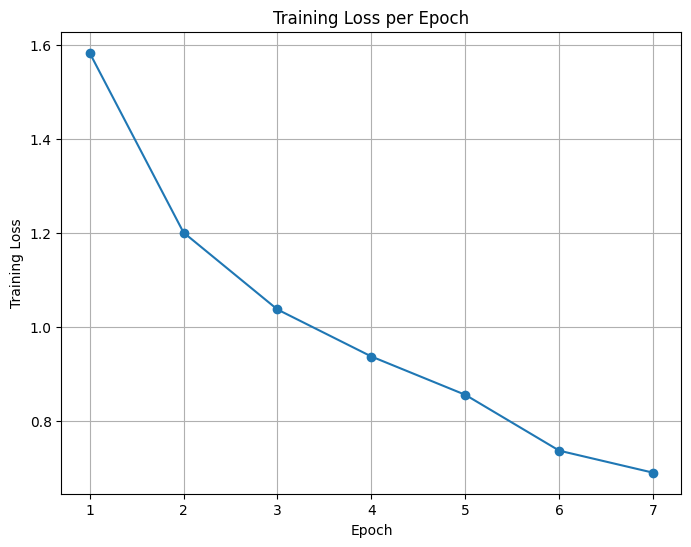

Test Accuracy on CIFAR-10: 74.82%


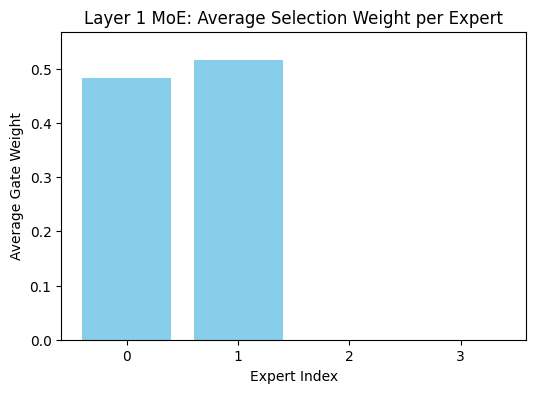

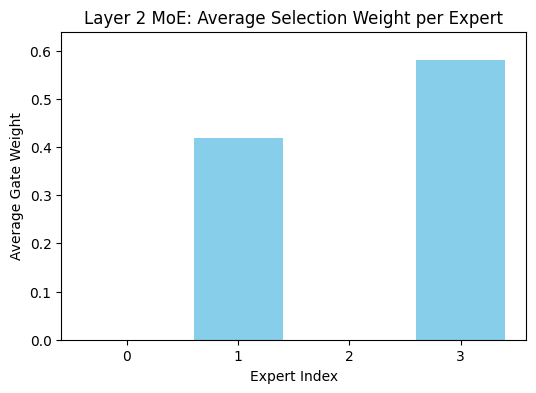

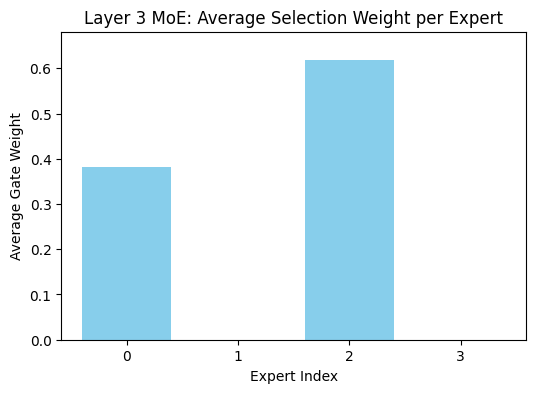

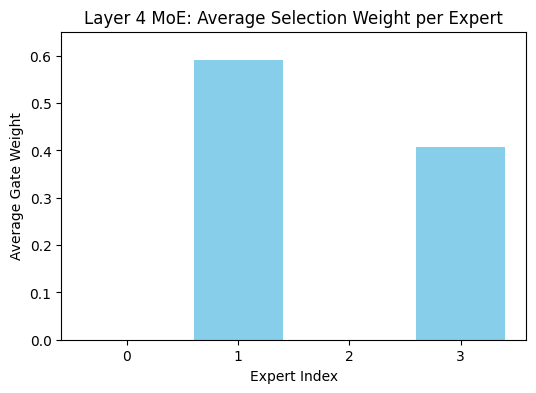

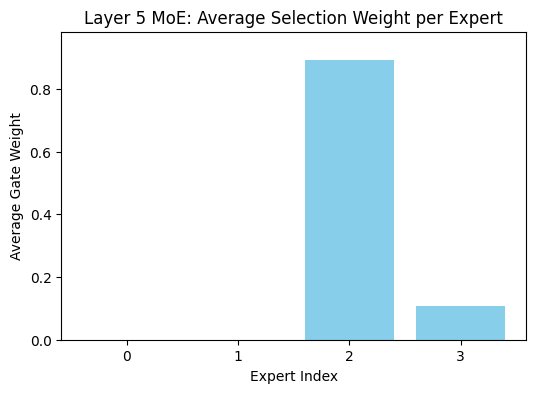

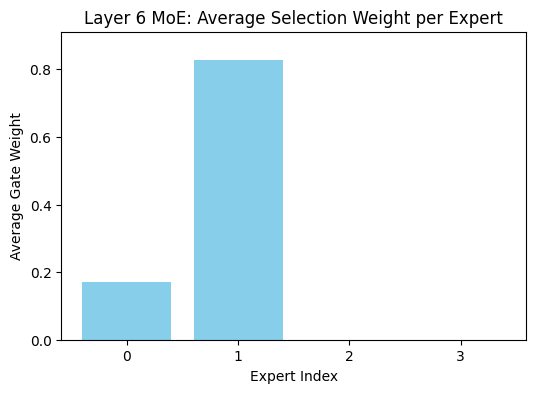

Epoch [8] Batch [10/391] Loss: 0.5364
Epoch [8] Batch [20/391] Loss: 0.5516
Epoch [8] Batch [30/391] Loss: 0.8022
Epoch [8] Batch [40/391] Loss: 0.6857
Epoch [8] Batch [50/391] Loss: 0.5411
Epoch [8] Batch [60/391] Loss: 0.6542
Epoch [8] Batch [70/391] Loss: 0.6057
Epoch [8] Batch [80/391] Loss: 0.5359
Epoch [8] Batch [90/391] Loss: 0.7436
Epoch [8] Batch [100/391] Loss: 0.6606
Epoch [8] Batch [110/391] Loss: 0.8135
Epoch [8] Batch [120/391] Loss: 0.6945
Epoch [8] Batch [130/391] Loss: 0.6173
Epoch [8] Batch [140/391] Loss: 0.7799
Epoch [8] Batch [150/391] Loss: 0.7475
Epoch [8] Batch [160/391] Loss: 0.7064
Epoch [8] Batch [170/391] Loss: 0.6154
Epoch [8] Batch [180/391] Loss: 0.6016
Epoch [8] Batch [190/391] Loss: 0.7769
Epoch [8] Batch [200/391] Loss: 0.8580
Epoch [8] Batch [210/391] Loss: 0.6903
Epoch [8] Batch [220/391] Loss: 0.7458
Epoch [8] Batch [230/391] Loss: 0.6103
Epoch [8] Batch [240/391] Loss: 0.4867
Epoch [8] Batch [250/391] Loss: 0.5381
Epoch [8] Batch [260/391] Loss: 0.

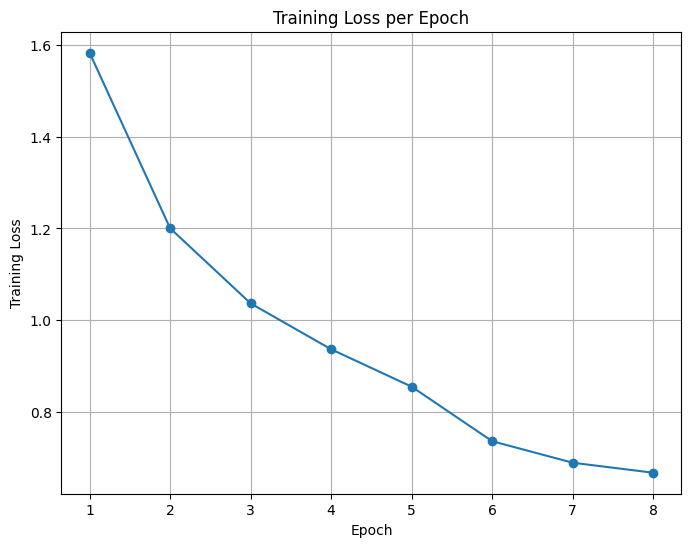

Test Accuracy on CIFAR-10: 76.09%


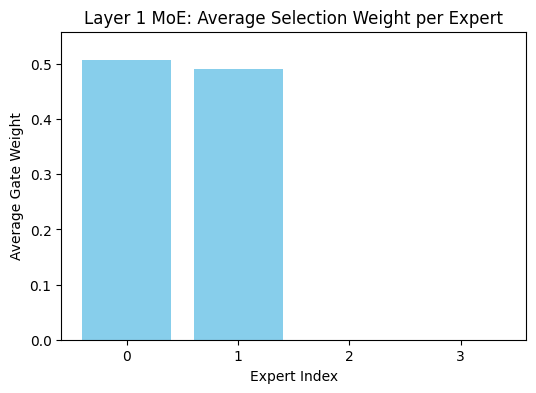

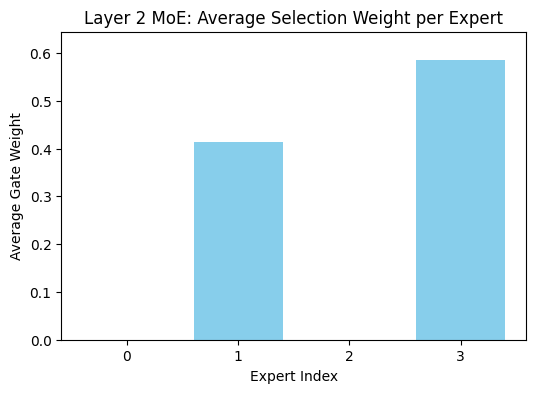

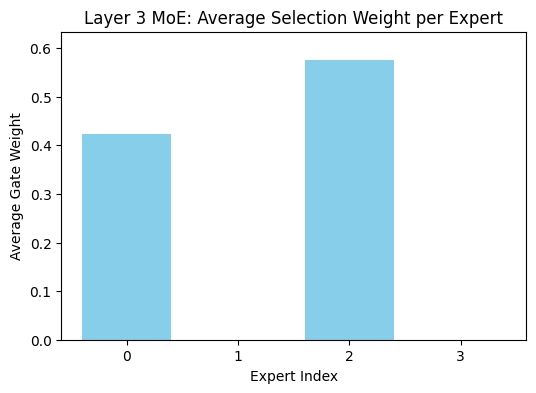

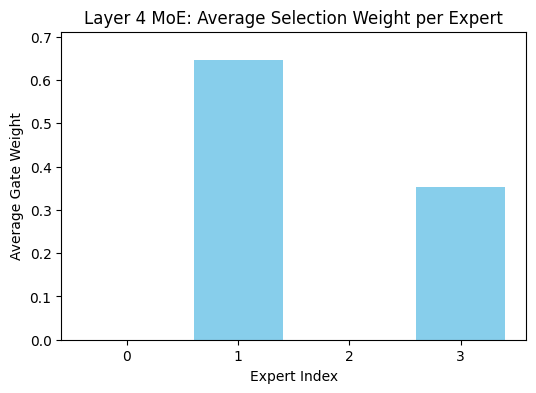

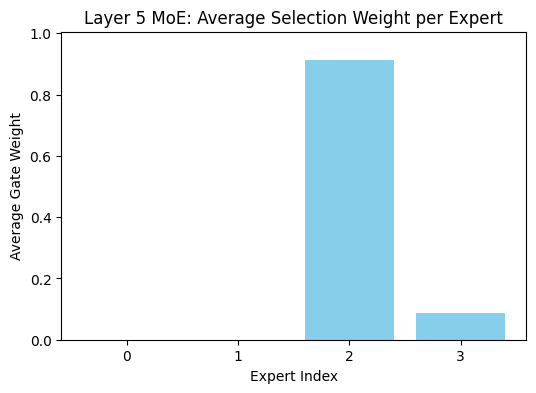

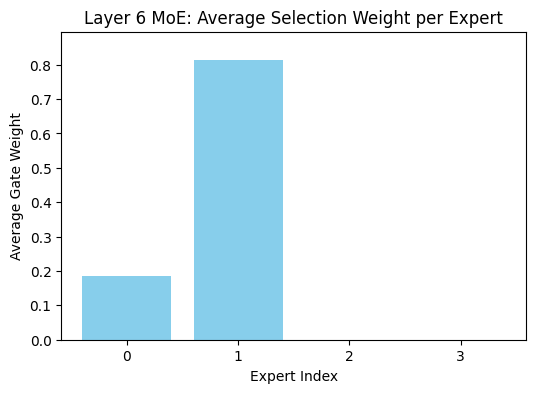

Epoch [9] Batch [10/391] Loss: 0.5445
Epoch [9] Batch [20/391] Loss: 0.7377
Epoch [9] Batch [30/391] Loss: 0.6536
Epoch [9] Batch [40/391] Loss: 0.6257
Epoch [9] Batch [50/391] Loss: 0.6618
Epoch [9] Batch [60/391] Loss: 0.6935
Epoch [9] Batch [70/391] Loss: 0.6188
Epoch [9] Batch [80/391] Loss: 0.6288
Epoch [9] Batch [90/391] Loss: 0.5795
Epoch [9] Batch [100/391] Loss: 0.7918
Epoch [9] Batch [110/391] Loss: 0.5277
Epoch [9] Batch [120/391] Loss: 0.6695
Epoch [9] Batch [130/391] Loss: 0.6547
Epoch [9] Batch [140/391] Loss: 0.6997
Epoch [9] Batch [150/391] Loss: 0.6460
Epoch [9] Batch [160/391] Loss: 0.6891
Epoch [9] Batch [170/391] Loss: 0.5633
Epoch [9] Batch [180/391] Loss: 0.6004
Epoch [9] Batch [190/391] Loss: 0.5665
Epoch [9] Batch [200/391] Loss: 0.6605
Epoch [9] Batch [210/391] Loss: 0.7248
Epoch [9] Batch [220/391] Loss: 0.7837
Epoch [9] Batch [230/391] Loss: 0.7585
Epoch [9] Batch [240/391] Loss: 0.5951
Epoch [9] Batch [250/391] Loss: 0.7636
Epoch [9] Batch [260/391] Loss: 0.

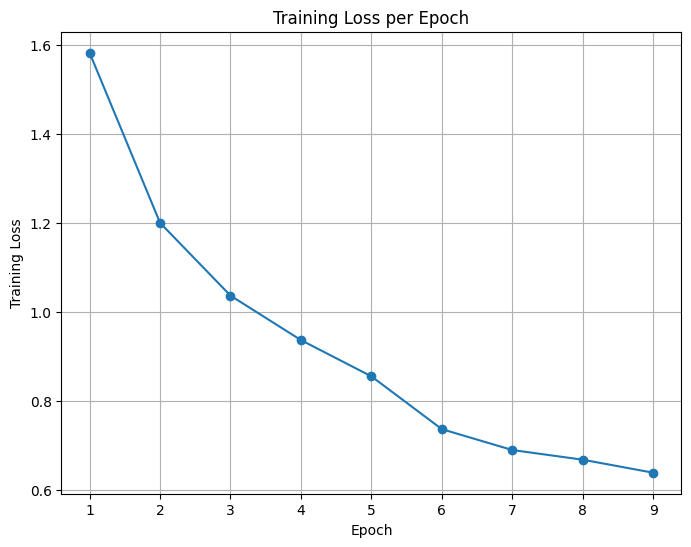

Test Accuracy on CIFAR-10: 76.54%


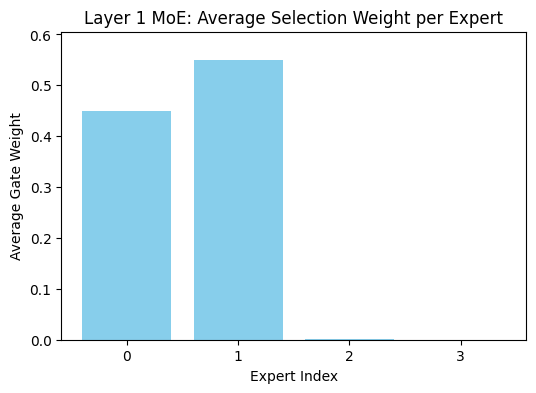

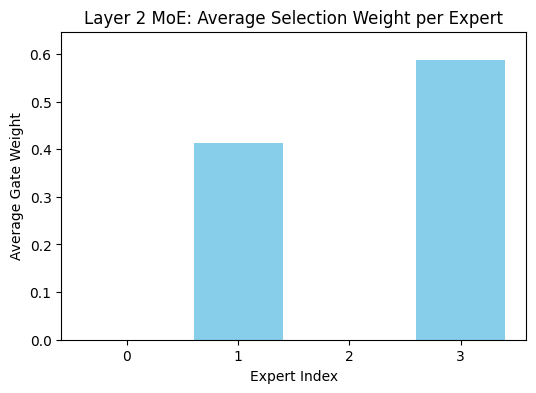

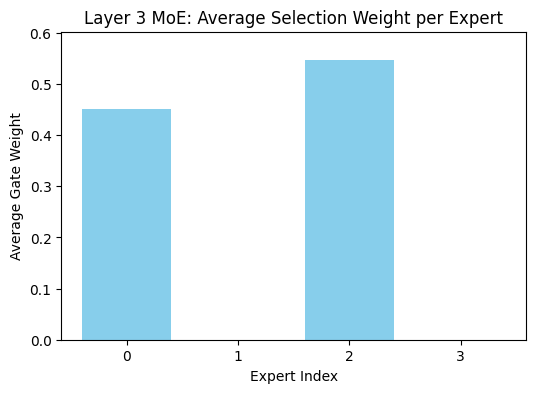

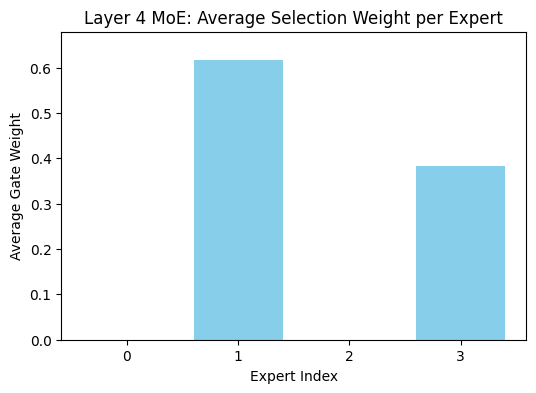

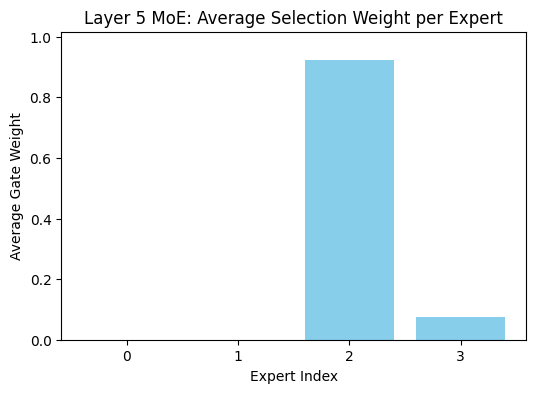

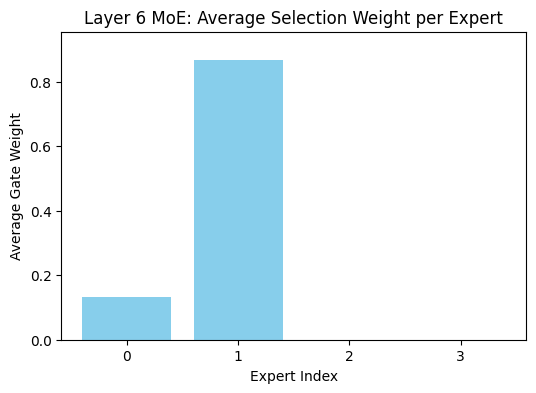

Epoch [10] Batch [10/391] Loss: 0.5010
Epoch [10] Batch [20/391] Loss: 0.4808
Epoch [10] Batch [30/391] Loss: 0.7339
Epoch [10] Batch [40/391] Loss: 0.6469
Epoch [10] Batch [50/391] Loss: 0.6061
Epoch [10] Batch [60/391] Loss: 0.3824
Epoch [10] Batch [70/391] Loss: 0.7692
Epoch [10] Batch [80/391] Loss: 0.5786
Epoch [10] Batch [90/391] Loss: 0.5235
Epoch [10] Batch [100/391] Loss: 0.5934
Epoch [10] Batch [110/391] Loss: 0.4973
Epoch [10] Batch [120/391] Loss: 0.6002
Epoch [10] Batch [130/391] Loss: 0.5656
Epoch [10] Batch [140/391] Loss: 0.6516
Epoch [10] Batch [150/391] Loss: 0.6043
Epoch [10] Batch [160/391] Loss: 0.5427
Epoch [10] Batch [170/391] Loss: 0.5951
Epoch [10] Batch [180/391] Loss: 0.5512
Epoch [10] Batch [190/391] Loss: 0.6645
Epoch [10] Batch [200/391] Loss: 0.5984
Epoch [10] Batch [210/391] Loss: 0.4817
Epoch [10] Batch [220/391] Loss: 0.6581
Epoch [10] Batch [230/391] Loss: 0.6201
Epoch [10] Batch [240/391] Loss: 0.6983
Epoch [10] Batch [250/391] Loss: 0.7903
Epoch [10

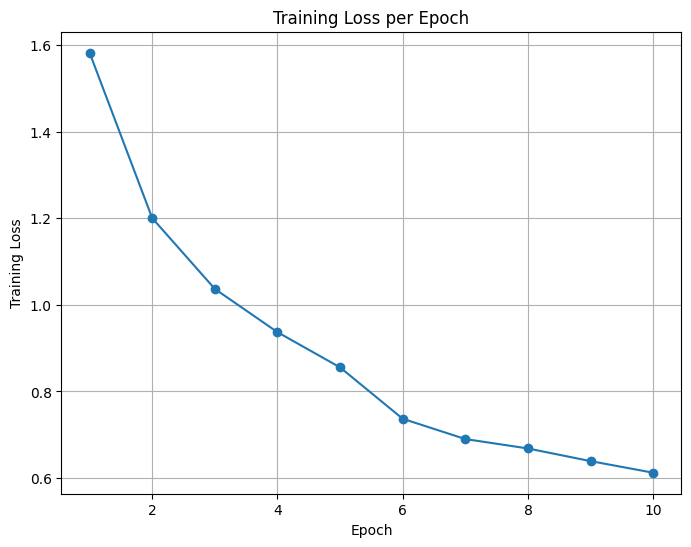

Test Accuracy on CIFAR-10: 76.53%


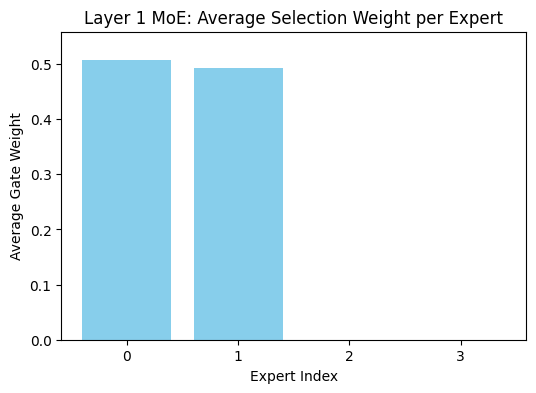

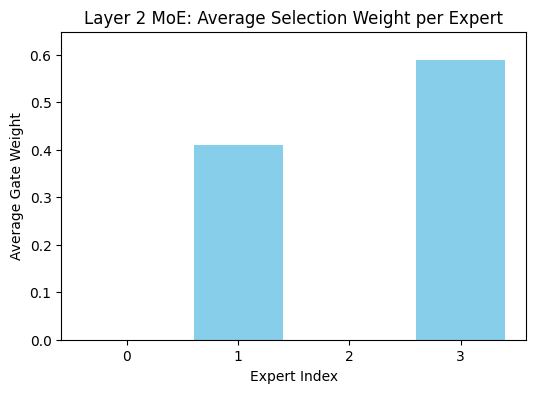

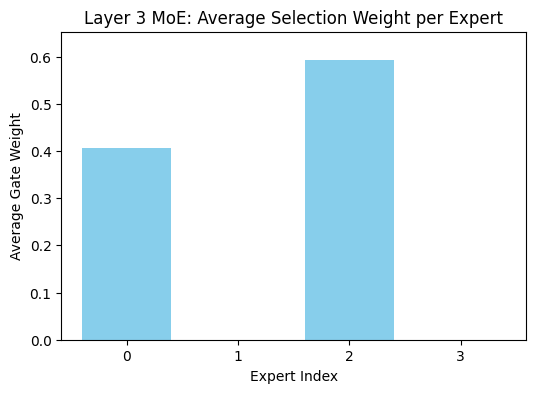

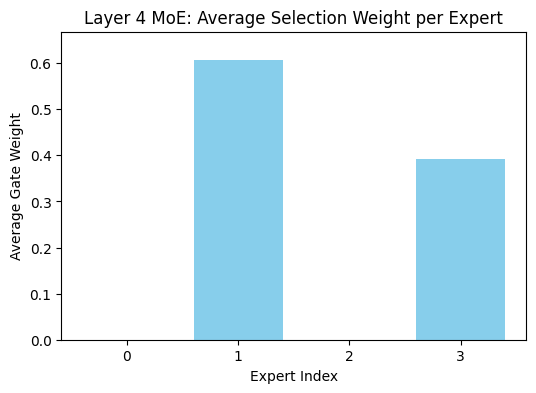

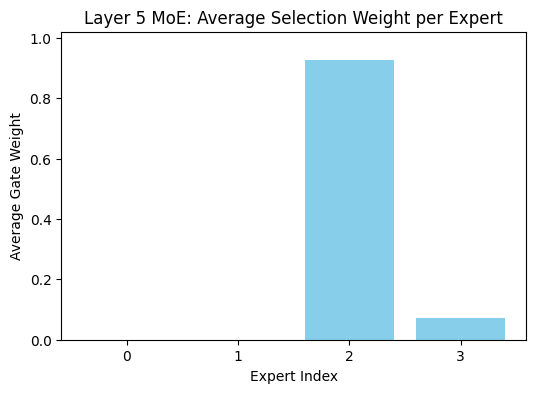

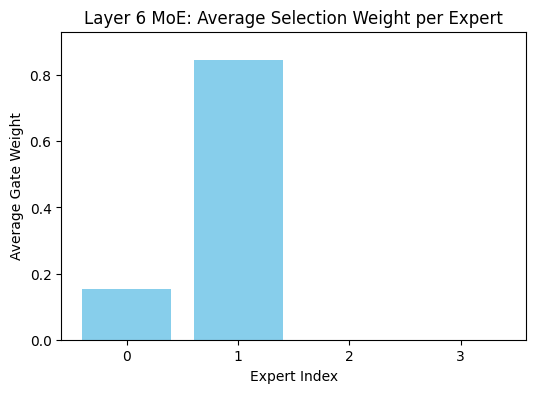

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# Expert Module
# -------------------------------
class Expert(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Expert, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        return F.relu(self.bn(self.conv(x)))

# -------------------------------
# Gating Network
# -------------------------------
class GatingNetwork(nn.Module):
    def __init__(self, in_channels, num_experts):
        super(GatingNetwork, self).__init__()
        self.gap = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling.
        self.fc = nn.Linear(in_channels, num_experts)

    def forward(self, x):
        out = self.gap(x).squeeze(-1).squeeze(-1)  # shape: [batch, in_channels]
        gate_logits = self.fc(out)
        gate_weights = F.softmax(gate_logits, dim=-1)
        return gate_weights

# -------------------------------
# MoE Block with top-k experts selection
# -------------------------------
class MoEBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_experts=4, k=2):
        """
        Args:
            in_channels: Number of input feature channels.
            out_channels: Number of output feature channels.
            num_experts: Total number of experts.
            k: Number of experts to select (top k).
        """
        super(MoEBlock, self).__init__()
        self.num_experts = num_experts
        self.k = k  # top-k experts to use
        self.experts = nn.ModuleList(
            [Expert(in_channels, out_channels) for _ in range(num_experts)]
        )
        self.gate = GatingNetwork(in_channels, num_experts)
        self.out_conv = nn.Conv2d(out_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x, return_gate=False):
        # Get gating weights [batch, num_experts]
        gate_weights = self.gate(x)

        # Keep only the top-k expert weights for each sample.
        # We get indices of the top k for every sample in the batch.
        topk_vals, topk_indices = torch.topk(gate_weights, k=self.k, dim=-1)

        # Create a mask that is 1 for topk indices and 0 for the rest.
        mask = torch.zeros_like(gate_weights)
        mask.scatter_(1, topk_indices, 1.0)

        # Multiply gate weights with the mask.
        gated_weights = gate_weights * mask

        # Re-normalize so that the sum is 1 over the selected experts.
        gated_sum = gated_weights.sum(dim=1, keepdim=True) + 1e-8  # adding epsilon for numerical stability
        gated_weights = gated_weights / gated_sum

        # Compute each expert's output.
        expert_outputs = [expert(x) for expert in self.experts]
        # Stack expert outputs: shape [batch, num_experts, out_channels, H, W]
        expert_stack = torch.stack(expert_outputs, dim=1)

        # Reshape gated_weights for elementwise multiplication.
        # new shape: [batch, num_experts, 1, 1, 1]
        gated_weights_expanded = gated_weights.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        # Combine expert outputs using the gated weights.
        out = (expert_stack * gated_weights_expanded).sum(dim=1)

        # Proceed with output processing.
        out = self.out_conv(out)
        out = self.bn(out)
        out = F.relu(out)

        if return_gate:
            # Return both output features and the (top-k re-normalized) gating weights.
            return out, gated_weights
        return out

# -------------------------------
# Downsample Block (Pooling + 1x1 Conv)
# -------------------------------
class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Downsample, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x)

# -------------------------------
# DeepMoE Model Definition
# -------------------------------
class DeepMoEModel(nn.Module):
    def __init__(self, input_channels=3, base_channels=64, num_experts=4, k=2, num_classes=10):
        super(DeepMoEModel, self).__init__()

        # Initial convolution block.
        self.initial = nn.Sequential(
            nn.Conv2d(input_channels, base_channels, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.stages = nn.ModuleList()
        current_channels = base_channels

        # Stage 1: Two MoEBlocks.
        stage1 = nn.Sequential(
            MoEBlock(current_channels, current_channels, num_experts=num_experts, k=k),
            MoEBlock(current_channels, current_channels, num_experts=num_experts, k=k)
        )
        self.stages.append(stage1)

        # Downsample stage: adjust channels for next stage.
        next_channels = current_channels * 2
        self.downsample1 = Downsample(current_channels, next_channels)
        current_channels = next_channels

        # Stage 2: Two MoEBlocks.
        stage2 = nn.Sequential(
            MoEBlock(current_channels, current_channels, num_experts=num_experts, k=k),
            MoEBlock(current_channels, current_channels, num_experts=num_experts, k=k)
        )
        self.stages.append(stage2)

        # Downsample stage.
        next_channels = current_channels * 2
        self.downsample2 = Downsample(current_channels, next_channels)
        current_channels = next_channels

        # Stage 3: Two MoEBlocks.
        stage3 = nn.Sequential(
            MoEBlock(current_channels, current_channels, num_experts=num_experts, k=k),
            MoEBlock(current_channels, current_channels, num_experts=num_experts, k=k)
        )
        self.stages.append(stage3)

        # Global Average Pooling and final classifier.
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(current_channels, num_classes)

    def forward(self, x, return_gate=False):
        x = self.initial(x)
        gate_outputs = []

        # Stage 1:
        for block in self.stages[0]:
            if isinstance(block, MoEBlock):
                if return_gate:
                    x, gate = block(x, return_gate=True)
                    gate_outputs.append(gate)
                else:
                    x = block(x)
            else:
                x = block(x)

        # Downsample after stage 1.
        x = self.downsample1(x)

        # Stage 2:
        for block in self.stages[1]:
            if isinstance(block, MoEBlock):
                if return_gate:
                    x, gate = block(x, return_gate=True)
                    gate_outputs.append(gate)
                else:
                    x = block(x)
            else:
                x = block(x)

        # Downsample after stage 2.
        x = self.downsample2(x)

        # Stage 3:
        for block in self.stages[2]:
            if isinstance(block, MoEBlock):
                if return_gate:
                    x, gate = block(x, return_gate=True)
                    gate_outputs.append(gate)
                else:
                    x = block(x)
            else:
                x = block(x)

        x = self.gap(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)

        if return_gate:
            return logits, gate_outputs
        return logits

# -------------------------------
# Evaluation function: Compute gating statistics
# -------------------------------
def evaluate_gating(model, device, test_loader):
    model.eval()
    gating_stats_list = []
    sample_count = 0

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            batch_size = data.size(0)
            sample_count += batch_size

            # Forward pass with gating outputs.
            _, gate_outputs = model(data, return_gate=True)

            for i, gate in enumerate(gate_outputs):
                if len(gating_stats_list) <= i:
                    gating_stats_list.append(gate.sum(dim=0))
                else:
                    gating_stats_list[i] += gate.sum(dim=0)

    gating_stats_list = [stats / sample_count for stats in gating_stats_list]
    return gating_stats_list

# -------------------------------
# Plotting function: Plot gating statistics
# -------------------------------
def plot_gating_statistics(gating_stats_list):
    for i, stats in enumerate(gating_stats_list):
        experts = np.arange(len(stats))
        stats_np = stats.cpu().numpy() if hasattr(stats, 'cpu') else stats
        plt.figure(figsize=(6,4))
        plt.bar(experts, stats_np, color='skyblue')
        plt.xlabel('Expert Index')
        plt.ylabel('Average Gate Weight')
        plt.title(f'Layer {i+1} MoE: Average Selection Weight per Expert')
        plt.xticks(experts)
        plt.ylim(0, np.max(stats_np) * 1.1)
        plt.show()

# -------------------------------
# Training Loop
# -------------------------------
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"Epoch [{epoch}] Batch [{batch_idx+1}/{len(train_loader)}] Loss: {loss.item():.4f}")

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch}] Average Loss: {avg_loss:.4f}")
    return avg_loss

# -------------------------------
# Main: Dataset Preparation, Training, Evaluation, and Plotting
# -------------------------------
def main():
    # Hyperparameters
    num_epochs = 10
    batch_size = 128
    learning_rate = 0.001
    top_k = 2  # Using only top-2 experts

    # Define CIFAR-10 transforms with data augmentation.
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                             std=[0.2470, 0.2435, 0.2616]),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                             std=[0.2470, 0.2435, 0.2616]),
    ])

    # Load CIFAR-10 training and test datasets.
    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize model, loss criterion, optimizer, and learning rate scheduler.
    model = DeepMoEModel(input_channels=3, base_channels=64, num_experts=4, k=top_k, num_classes=10)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    # List to store training losses.
    train_losses = []

    print("Starting training on CIFAR-10 with Top-2 Expert Selection...")
    for epoch in range(1, num_epochs + 1):
        loss = train(model, device, train_loader, optimizer, criterion, epoch)
        train_losses.append(loss)
        scheduler.step()  # Step the scheduler.

        # Plot training loss over epochs.
        plt.figure(figsize=(8, 6))
        plt.plot(range(1, epoch+1), train_losses, marker='o')
        plt.xlabel('Epoch')
        plt.ylabel('Training Loss')
        plt.title('Training Loss per Epoch')
        plt.grid(True)
        plt.show()

        # Evaluate model on test dataset.
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, targets in test_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        accuracy = 100. * correct / total
        print(f"Test Accuracy on CIFAR-10: {accuracy:.2f}%")

        # Evaluate gating statistics and plot them.
        gating_stats = evaluate_gating(model, device, test_loader)
        plot_gating_statistics(gating_stats)

if __name__ == '__main__':
    main()
